In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy import io
from timeit import Timer
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples, adjusted_rand_score

In [3]:
plt.style.use('seaborn-whitegrid')

# Comparison Between PCA, t-SNE, and UMAP for Dimensionality Reduction and Visualization of scRNA-seq Data

### Author: Vladimir Stoev

### Abstract

Single-cell RNA-sequencing (scRNA-seq) is a powerful new technology that is providing key insights into both human physiology and disease. In contrast to bulk RNA-sequencing, where the average expression of all cells in a sample is measured, scRNA-seq allows researchers to measure gene expression in each cell individually. Thus, scRNA-seq experiments yield ever growing data containing RNA expression levels for thousands of genes from many thousands up to millions of cells. Computational analysis of such data is challenging and often entails unsupervised, exploratory steps including dimensionality reduction for data visualisation. Moreover, in order for scRNA-seq technology to reach its full potential, specifically tailored and highly scalable dimension reduction and visualization algorithms are required for catching up with the increasingly larger scRNA-seq datasets. This presents an unique challenge in the anasysis of scRNA-seq data, and currently making this area of research very active. Throughout this project we will go through examination of the three most commonly used techniques for dimensionality reduction and visualization of scRNA-seq data, namely PCA, t-SNE, and UMAP. We will see which are their strengths and weaknesses when it comes to dimension reduction and visualization and in what circumstances they are applicable.

### I. Introduction to scRNA-seq

Within the last decade the field of gene expression analysis has dramatically changed due to the emergence of a new technolgy that enables unprecedented examination of the transcriptome at single cell resolution. This single-cell transcriptomics technology referred to as single-cell RNA-seq or scRNA-seq allows recearchers to obtain genome-wide transcriptome profile from single cells using next-generation sequencing. First attempts for high-throughput sequencing of single cells can be traced back to 2009 when _Tang et al._ [1] menaged to sequence a handful of murine primordial germ cells. Before that gene expression measurements were performed on "bulk" samples containing populations of thousands or millions of cells. Standard methods such as microarrays and bulk RNA-seq analyze the expression of RNAs from large populations of cells. In mixed cell populations, these measurements may obscure critical differences between individual cells within the populations. In contrast, scRNA-seq provides the expression profiles of individual cells and is considered the gold standard for defining cell states and phenotypes as of 2020.

From its first publication in 2009 until 2014 scRNA-seq did not gain widespread popularity among the scientific community due to high sequencing costs and lack of refined protocols. Regardless of that, development of new methods and protocols for scRNA-seq have dramatically changed and revolutionize many life science research areas, ranging from immunology, oncology, and neuroscince to stem cells research, plant physiology and most recently COVID-19 research. Overall, experimental scRNA-seq protocols are similar to the methods used for bulk RNA-seq. The methods can be categorized in different ways, but the two most important aspects are __quantification__ and __capture__ of the RNA transcripts. For quantification, there are two types, __full-length__ and __tag-based__ approaches. The former tries to achieve a uniform read coverage of each transcript. By contrast, tag-based protocols only capture either the 5’- or 3’-end of each RNA transcript. The choice of quantification method has important implications for what types of analyses the data can be used for. The strategy used for capturing of the transcripts, determines throughput, how the cells can be selected as well as what kind of additional information besides the sequencing can be obtained. The three most widely used options for capturing cingle cells are __microwell-__, __microfluidic-__ and __droplet- based__.

***

<img src="Data/DyTKwxIVsAAAj5W.jpg" alt="Drawing" width="750"/>

***

The output from single cell sequencing methods has increased significantly for the last few years. As we can see from the image above, there has been exponential increase in number of cells that have been processed in different studies, with each of the circles representing a different publication and the number of cells being analyzed. The earlier techniques that were used, analyzed individual cells by sorting them into a separate wells of a plate, and preparing libraries from each of those individual cells, and then sequence them. For example, the plate-based _SMART-seq_ technique use flow cytometer which sort one cell into each well of 96- or 384-well plate. Subsequently, these cells have to be lysed, and then a reverse transcription reaction have to be performed using a SMART-seq style library preparation. In brief, an oligo-dT and template-switch primers are used to convert mRNA transcripts into cDNA molecules. These primers have 'handles' that are used for further amplification of the cDNAs via PCR. The library preparation process ends with addition of adapter sequences that binds to the amplified cDNAs, and provide sites for attachment to complementary ologonucleotides placed on the surface of the sequencer flow cell. Next, NGS is employed to sequence the libraries. These methods are considered low-throughput, because one is able to process a few hundreds to few thousands cells with considerable amount of work, because each cell is processed separately.

On the other hand, microfluidic platforms, such as _Fluidigm’s C1_  provide a more integrated system for capturing cells and for carrying out the reactions necessary for the library preparations. Thus, they provide a higher throughput than microwell based platforms. As a drawback can be metioned that only around 10% of cells are captured by a microfluidic device, thus rendering them not appropriate if one is dealing with rare cell-types or very small amounts of input. 

The idea behind droplet-based methods is to encapsulate each individual cell inside a nanoliter droplet together with a bead. The bead is loaded with the enzymes required to construct the library. In particular, each bead contains a unique barcode which is attached to all of the reads/transcripts originating from that cell. Thus, all of the droplets can be pooled and sequenced together and the reads can subsequently be assigned to the cell of origin based on the barcodes. Droplet-based platforms like _10x Genomics_ typically have the highest throughput since the library preparation costs are on the order of .05 USD/cell and up to 200 000 cells can be processed within a day on a single chip.

Once the libraries came out from the sequencer, begins the computational analysis of the obtained reads. In general, this analysis can be divided in three stages. First, the overall quality of the reads generated by the sequncing instrument is verified. Sequencers produce files in FASTQ format, which files store information for the raw sequence data and quality scores assigned for each base in the reads. These scores reflect the probability that the given base was called correctly. All reads with quality score below predefined threshold are excluded, as well as reads shorter than 20 nucleotides. As a next step, adapter sequence and barcode trimming is performed to exclude already unnecessary additional sequences. The first stage ends with re-checking the quality of the trimmed data. 

In the second stage, the high quality reads are aligned to a reference genome and transcript level counts are generated. There are various tools available for aligning the raw reads, but important consideration is the chosen aligner to be "splice-aware". Once the alignment is completed, the next step is to check how many reads aligned to the genome. For RNA-seq of human samples, for good quality data, about 70 - 90% of the reads should match somewhere on the genome. If the data in question are of good quality but less than 60% of the reads are mapping to the genome, it is worth evaluating the parameters of the alignment. Once it is determined that the alignment step was successful, the next step is to enumerate the number of reads that are associated with the genes, which eventally outputs a raw counts matrix.

The final stage of any scRNA-seq computational analysis is the statistical analysis of the obtained raw counts. At this stage many machine learning approaches come into play. Distinctive features of the count matrices generated in scRNA-seq experiments are the high-dimensionality and the sparseness of the data. This is so, because the human genome, for example, contains around 20 000 genes without counting the different isoforms of those genes, which grossly can exceed 100 000. Moreover, in a typical scRNA-seq experiment, especially performed with the aid of platforms such as 10x Genomics, can be sequenced more than 1 000 000 cells, in parallel. In 2017, was generated the largest dataset to date, using scRNA-seq, containing information for more than 1.3 million embryonic mice brain cells. Hence, a count matrix produced from scRNA-seq experiment is with dimensions 20 000 rows X usally 10 000 to 100 000 columns, in some extrime cases up to 1.3 million columns. On the other hand, typically between 5 and 25% of the genes are captured. This low number of expression alongside with the huge number of sequenced cells address the issues with the sparseness and high-dimensionality of the data. Therefore, the analysis of scRNA-seq data is challenging enterprise, and currently very active area of research, with most efforts concentrated in finding ways for meaningful visualization of these huge datasets.  

The goal of this project is to focus on the entire process of analysis of scRNA-seq data, from the initial preprecessing and normalization steps, through the dimensionality reduction and clustering, as we ultimately aim to compare, the considered for gold standard algorithm for visualization of scRNA-seq data - t-Distributed Stochastic Neighbor Embedding (t-SNE), with the most recently introduced and pronounced competitor - Uniform Manifold Approximation and Projection (UMAP).  

### II. Data Loading and Exploration

The data analyzed whitin this project were obtained from Single Cell Expression Atlas - a free online resource for scRNA-seq data governed by the European Bioinformatics Institute (EBI). 

The actual data were collected by _Tran et al._ [2] in a study conducted on human podocytes - epithelial cells that form the lining of Bowman's capsule in the kidneys. The study aims at finding developmental trajectories of human fetal podocytes, and to compare these trajectories to podocyte-like cells derived form kidney organoids generated from pluripotent human stem cells. 

The study has been carried out following the droplet-based 10x Genomics protocol. More information about the experimental description and protocol is provided in the metadata file below.

In [4]:
with open('Data/E-GEOD-124472.idf.txt', 'r', encoding = 'utf-8') as file:
    content = file.read()

In [5]:
print(content)

MAGE-TAB Version	1.1				
Investigation Title	Single cell RNA-Seq profiling of human embryonic kidney outer and inner cortical cells and kidney organoid cells				
Experiment Description	To study the developmental process of human podocytes and compare to the in vitro counterpart, we dissociated cells from the inner and outer kidney cortex as well as kidney organoids, and performed 10X Genomics single-cell RNA sequencing. Identifying cell types and studying human podocyte developmental process in human kidney and in organoids				
Public Release Date	2019-06-19				
Person Last Name	McMahon	Ransick	Tran	Lindstrom	De Sena Brandine
Person First Name	Andrew	Andrew	Tracy	Nils	Guilherme
Person Mid Initials	P		T	O	
Person Email	amcmahon@med.usc.edu				
Person Affiliation	University of Southern California				
Person Phone	323-442-7847				
Person Address	Stem Cell Biol & Regen Med, University of Southern California, 1425 San Pablo St, BCC 312, Los Angeles, California, USA				
Person Roles	submitte

As we underscored in the introduction, a characteristic feature of the single-cell sequencing data is its low density (~10-15% of the entries are non-zero entries). Because of that, often scRNA-seq data are stored as sparse matrix objects to cope with this low data density. Such is the case with the single cell expression atlas repository - once the data folder is downloaded and unzipped, the folder contains three files:

- `matrix.mtx`: the read values of the gene expression matrix and their respective row and column indices, in a Matrix Market format.

- `barcodes.tsv`: a file containing the column (cell) labels.

- `genes.tsv`: a file containing the row (gene) labels.

Mtx files store Matrix Market format matrices. The base principle is to store the row and column indices of each non-zero entry in the matrix. This type of matrices can not be read with pandas, however the scipy module `io` offers a fucntion that can read the contents of such files, and returns `ndarray` or `coo_matrix` onjects of dense or sparse data depending on the matrix format in the mtx file.

So, let's use this module to read our `mtx` file.

In [6]:
mtx_matrix = io.mmread('Data/E-GEOD-124472.aggregated_filtered_counts.mtx_3.mtx')

In [7]:
mtx_matrix

<20782x10361 sparse matrix of type '<class 'numpy.float64'>'
	with 22195417 stored elements in COOrdinate format>

In [8]:
type(mtx_matrix)

scipy.sparse.coo.coo_matrix

As we can see, our `mtx_matrix` variable represents sparse matrix object, that explicitly have to be casted to `ndarray` with the aid of methods like - `toarray` or `todense`. 

In [9]:
mtx_matrix.toarray()

array([[1. , 0. , 0. , ..., 2. , 1. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 1. , ..., 2. , 1. , 1. ],
       ...,
       [0. , 0. , 0. , ..., 0.5, 0. , 0. ],
       [0.5, 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [10]:
type(mtx_matrix.toarray())

numpy.ndarray

Now let's verify the shape of our sparse matrix.

In [11]:
print(f'{mtx_matrix.shape[0]} rows X {mtx_matrix.shape[1]} columns')

20782 rows X 10361 columns


It consists of more than 20 000 rows and 10 000 columns. That is definitely high dimensional.

Now, as the gene and barcode labels are stored in separate files, we also need to read them. First, we will read the barcode (cell) labels. They are stored in `tsv` file, so we will not have problems to load them with pandas. 

In [12]:
cells = pd.read_csv('Data/E-GEOD-124472.aggregated_filtered_counts.mtx_cols_3', sep = '\t', header = None, names = ['CELL BARCODES'])

In [13]:
cells

CELL BARCODES
0      SRR8377704-GTTCTCGCACGACGAA
1      SRR8377704-GTTCTCGCATGCTGGC
2      SRR8377704-GTTCTCGGTTGATTGC
3      SRR8377704-GTTCTCGTCATATCGG
4      SRR8377704-GTTCTCGTCGTTACAG
...                            ...
10356  SRR8377710-ATGGGAGGTCTCTTAT
10357  SRR8377710-ATGGGAGGTGCAACTT
10358  SRR8377710-ATGGGAGTCAGCTCGG
10359  SRR8377710-ATGTGTGAGGCAAAGA
10360  SRR8377710-ATGTGTGAGTGGTCCC

[10361 rows x 1 columns]

Each cell is represented with its unique barcode label, depending on the bead that the cell have been trapped with. This approach is really efficient, because as we outlined above, it allows the libraries to be constructed inside a nanoliter droplets, meaning all enzymatic reaction can take place inside the droplets, and subsequently all cells can be poolled together for sequencing. In other words, the barcodes ensure the cell of origin of each transcript. 

We will use these cell barcodes as column names for our prospective dataframe, therefore we must convert them to `pd.Series` object. 

Let's do that.

In [14]:
cells = pd.Series(cells.loc[:, 'CELL BARCODES'])

In [15]:
cells

0        SRR8377704-GTTCTCGCACGACGAA
1        SRR8377704-GTTCTCGCATGCTGGC
2        SRR8377704-GTTCTCGGTTGATTGC
3        SRR8377704-GTTCTCGTCATATCGG
4        SRR8377704-GTTCTCGTCGTTACAG
                    ...             
10356    SRR8377710-ATGGGAGGTCTCTTAT
10357    SRR8377710-ATGGGAGGTGCAACTT
10358    SRR8377710-ATGGGAGTCAGCTCGG
10359    SRR8377710-ATGTGTGAGGCAAAGA
10360    SRR8377710-ATGTGTGAGTGGTCCC
Name: CELL BARCODES, Length: 10361, dtype: object

In [16]:
type(cells)

pandas.core.series.Series

Now, we must approach to reading our gene symbols, which will be the indices of the dataframe.

In [17]:
genes = pd.read_csv('Data/E-GEOD-124472.aggregated_filtered_counts.mtx_rows_3', sep = '\t', header = None, names = ['GENES'])

In [18]:
genes

GENES
0            TSPAN6
1              TNMD
2              DPM1
3             SCYL3
4          C1orf112
...             ...
20777    AP001931.2
20778       C3orf36
20779    AC018809.3
20780  DUS4L-BCAP29
20781    AL355385.2

[20782 rows x 1 columns]

We must also cast them to `pd.Series` object, in order to be able to use them as indices of the dataframe. 

In [19]:
genes = pd.Series(genes.loc[:, 'GENES'])

In [20]:
genes

0              TSPAN6
1                TNMD
2                DPM1
3               SCYL3
4            C1orf112
             ...     
20777      AP001931.2
20778         C3orf36
20779      AC018809.3
20780    DUS4L-BCAP29
20781      AL355385.2
Name: GENES, Length: 20782, dtype: object

In [21]:
type(genes)

pandas.core.series.Series

Everything looks good. 

Now, we will construct our dataframe by using the mtx sparse matrix as our data, and the gene and cell labels as indices and columns of the dataframe, respectively.

In [22]:
raw_counts = pd.DataFrame(data = mtx_matrix.toarray(), index = genes, columns = cells)

In [23]:
raw_counts

CELL BARCODES  SRR8377704-GTTCTCGCACGACGAA  SRR8377704-GTTCTCGCATGCTGGC  \
GENES                                                                     
TSPAN6                                 1.0                          0.0   
TNMD                                   0.0                          0.0   
DPM1                                   0.0                          0.0   
SCYL3                                  0.0                          0.0   
C1orf112                               0.0                          0.0   
...                                    ...                          ...   
AP001931.2                             1.5                          0.0   
C3orf36                                0.0                          0.0   
AC018809.3                             0.0                          0.0   
DUS4L-BCAP29                           0.5                          0.0   
AL355385.2                             0.0                          0.0   

CELL BARCODES  SRR8377704-GTTCTCGGTTGATTGC  SRR8377704-GTTCTCGTCATATCGG  \
GENES                                                                     
TSPAN6                                 0.0                          0.0   
TNMD                                   0.0                          0.0   
DPM1                                   1.0                          1.0   
SCYL3                                  0.0                          0.0   
C1orf112                               0.0                          0.0   
...                                    ...                          ...   
AP001931.2                             0.0                          0.0   
C3orf36                                0.0                          0.0   
AC018809.3                             0.0                          0.0   
DUS4L-BCAP29                           0.0                          0.5   
AL355385.2                             0.0                          0.0   

CELL BARCODES  SRR8377704-GTTCTCGTCGTTACAG  SRR8377704-GTTCTCGTCTAGAGTC  \
GENES                                                                     
TSPAN6                                 0.0                          0.0   
TNMD                                   0.0                          0.0   
DPM1                                   0.0                          0.0   
SCYL3                                  0.0                          0.0   
C1orf112                               0.0                          0.0   
...                                    ...                          ...   
AP001931.2                             0.5                          0.0   
C3orf36                                0.0                          0.0   
AC018809.3                             0.0                          0.0   
DUS4L-BCAP29                           0.0                          0.5   
AL355385.2                             0.0                          0.0   

CELL BARCODES  SRR8377704-GTTCTCGTCTCCTATA  SRR8377704-GTTTCTAAGAGCTATA  \
GENES                                                                     
TSPAN6                                 0.0                          1.0   
TNMD                                   0.0                          0.0   
DPM1                                   0.0                          2.0   
SCYL3                                  0.0                          0.0   
C1orf112                               0.0                          0.0   
...                                    ...                          ...   
AP001931.2                             0.0                          0.0   
C3orf36                                0.0                          0.0   
AC018809.3                             0.0                          0.0   
DUS4L-BCAP29                           0.0                          0.5   
AL355385.2                             0.0                          0.0   

CELL BARCODES  SRR8377704-GTTTCTAAGGCCGAAT  SRR8377704-GTTTCTACAGATCTGT  ...  \
GENES           

Voila, we already have a `pd.DataFrame`, consisting of the raw counts obtained from the upstream analysis of the data. 

A bit more details about the numbers in the dataframe in a while, now let's check the dimensions. 

In [24]:
print(f'{raw_counts.shape[0]} rows X {raw_counts.shape[1]} columns')

20782 rows X 10361 columns


Looks good. 

Now, because our dataframe is high-dimensional, it is a good idea to verify if there are any duplicated index or column names, because if so they will cause problems.

In [25]:
print(f'{raw_counts.index.nunique()} unique row names X {raw_counts.columns.nunique()} unique columns names')

20753 unique row names X 10361 unique columns names


In fact, there are duplicated indices, hence we must exclude them from the dataframe. 

In [26]:
raw_counts = raw_counts[~raw_counts.index.duplicated(keep = 'first')]

Let's see what we got.

In [27]:
print(f'{raw_counts.shape[0]} rows X {raw_counts.shape[1]} columns')

20753 rows X 10361 columns


It looks like we got rid of the duplicated gene symbols.

Now, we can look at some basic information about our dataframe, because it contains more than 10 000 columns, and that engages a lot of RAM memory.

In [28]:
raw_counts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20753 entries, TSPAN6 to AL355385.2
Columns: 10361 entries, SRR8377704-GTTCTCGCACGACGAA to SRR8377710-ATGTGTGAGTGGTCCC
dtypes: float64(10361)
memory usage: 1.6+ GB


Memory usage: 1.6+ GB. That is a lot. Since we will be carrying out various computations with this dataset, and that might drastically increase the memory usage, we should delete all unnacessary data. For example, we will not need any more the `mtx_matrix` variable that stores the sparse matrix data, since we already have a dense dataframe, so we can delete it. 

In [29]:
del mtx_matrix

Now, before we continue with the exploration of all those numbers in the dataset, we will explain the nature of the numbers, and why there are some halves. Was not it supposed these numbers to be integers, since they came out from the aligner as reads mapped to the given gene. Before we account fot that, we should first get familiar with what is a read, and is there any difference between a read and transcript. 

In principle, more than 90% of the sequencing platforms use the so called - short-read sequencing by synthesis approach introduced by Illumina. We will not go into details what is sequencing by synthesis, we will only say that due to limitations of this approach, the length of the nucleic acids that are sequenced can not exceed 300 bases. In the case of RNA, a typical length of a transcript is between 10 and 20 kilobases. This imposes the constructed cDNA libraries to be fragmented to appropriate length before adopters to be added. Therefore, a single transcript that should match to a single gene on a reference genome, in the process of sequencing is composed of many fragments called reads. During the process of determining the counts of each transcript, all reads are aligned on the reference genome, and the aligner gives an integer number for each transcript (gene). But, what is that all about? When one obtains the raw count results from the alignter, those numbers should be normalized by two parameters - ___sequencing depth___ and ___gene length___. By sequencing depth or coverage is meant the number of unique reads that include a given nucleotide when they are mapped on the genome, with simple words - how many reads match to that part of the genome. By gene length is considered, the length of the exons of the gene in kilobases. Gene length is taken into account because longer genes have more reads mapping to them, and that can introduce biases in the  downstream analysis.

scRNA-seq raw data is by far reported as three common units - RPKM, FPKM or TPM. RPKM and FPKM are essentially the same, and mean - Reads/Fragments Per Kilobase of exon per Million, while TPM abbreviate for - Transcripts Per Million.
The only difference between RPKM and FPKM is that, RPKM is used for single-end RNA-seq where every read correspond to a single fragment that was sequenced. FPKM is used for paired-end RNA-seq. With paired-end RNA-seq, two reads can correspond to a single fragment, or, if one read in the pair did not map, one read can correspond to a single fragment. But, how are these RPKM and FPKM values calculated, and why is that necessary, at all.  


 1. The total number of reads in a sample/cell have to be counted, and then divided by - 1,000,000 – this is the “per million” scaling factor.
    
    
 2. The read counts have to be divided by the “per million” scaling factor. This normalizes for sequencing depth, giving the reads per million (RPM).
 
 
 3. RPM values have to be devided by the length of the gene, in kilobases. This gives - RPKM, or FPKM, respectively. 


But, why is that necessary? Most of the time, the reason people perform scRNA-seq is to quantify and compare gene expression levels. In theory, scRNA-seq is ratio-level data, and you should be legitimately able to compare Gene A in Cell 1 vs. the same Gene A in Cell 2, as well as Gene A vs. Gene B within Cell 1. And these kinds of normalizations make it possible to compare Gene A to Gene B even if they are of different lengths. Per million reads means this value is then normalized against the library size. This bit of magic makes it possible to compare Gene A in Cell 1 to Cell 2 even if Cell 1′s library has 60 million pairs of reads and Cell 2′s library has only 30 million pairs of reads.

TPM is very similar to RPKM and FPKM. The only difference is the order of operations - they are switched. First, the counts are devided by the length of the gene, which gives - reads per kilobase (RPK). Then all RPK values are counted up in the given cell and divided by 1,000,000. That gives the “per million” scaling factor. At the end, the RPK values are divided by the “per million” scaling factor. That gives TPM.

We strongly believe that all those explanation were necessary, because we should be well familiar with the nature of data that we tackle with, because in our case the values in the dataset are reads per kilobase (RPK). That means that the estimated numbers of transcripts are only devided by the length of the exons of the given gene. Say, if the aligner counted 4 transcripts for Gene A with exon length 8, we would get 0.5 in the raw counts matrix. In other words, the values are normalized by gene length, but are not normalized by sequencing depth. Hence, we will have the honor to complite this normalization process in order to recieve TPM values. Thus, we can legimately compare gene expression lavels between the different cells. 

But before we scale/normalize our data, let's first explore it a litle bit.

We will begin with inspecting the cells quality. Typically, between 5 and 25% of the genes are captured during the process of library preparation. Inevitably, there are always some rare transcripts that are omitted in the process of reverse transcription and the subsequent amplification. Cells with less than 5% captured genes are considered with low quality. On the other hand, in the microfluidic cell when the cells are trapped in the oil droplets, sometimes two cells can fall into single droplet, thus that also will introduce biases into the transcripts representation. 

So, let's take a look at the percentage of gene expression for our cells.

In [30]:
percentage_expression = raw_counts[raw_counts > 0].count() / float(raw_counts.shape[0]) * 100

In [31]:
percentage_expression

CELL BARCODES
SRR8377704-GTTCTCGCACGACGAA    10.398497
SRR8377704-GTTCTCGCATGCTGGC     8.702356
SRR8377704-GTTCTCGGTTGATTGC    10.152749
SRR8377704-GTTCTCGTCATATCGG     8.427697
SRR8377704-GTTCTCGTCGTTACAG     8.596348
                                 ...    
SRR8377710-ATGGGAGGTCTCTTAT    10.225028
SRR8377710-ATGGGAGGTGCAACTT     7.724184
SRR8377710-ATGGGAGTCAGCTCGG    12.383752
SRR8377710-ATGTGTGAGGCAAAGA     9.155303
SRR8377710-ATGTGTGAGTGGTCCC     7.348335
Length: 10361, dtype: float64

It is a good idea to plot a histogram for those percents. Since we will presumably need to plot other histograms, we will write function that will aid with that.

In [32]:
def plot_hist(data_to_plot, bins = 'fd', figsize = (8, 6), title = None, x_label = None, y_label = None):
    """
    Plot a histogram.
    """
    plt.figure(figsize = figsize)
    plt.hist(data_to_plot, bins = bins, alpha = 0.8)
    plt.title(title, fontsize = 13)
    plt.xlabel(x_label, fontsize = 12)
    plt.ylabel(y_label, fontsize = 12)
    plt.show()

Now, let's plot those percents.

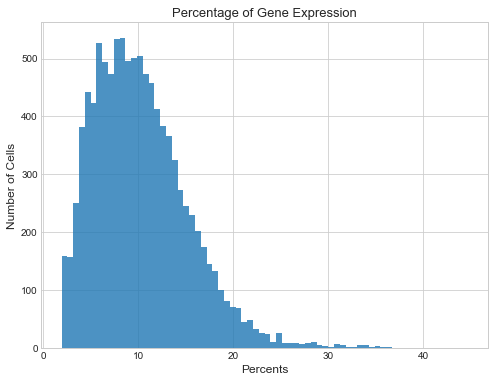

In [33]:
plot_hist(percentage_expression, 
          title = 'Percentage of Gene Expression', 
          x_label = 'Percents', 
          y_label = 'Number of Cells')

As we can see from the histogram, the distribution is slightly skewed toward the lower gene expression border, with mean expression around 10%. That is not so bad. However, there is also substantial amount of cells that are with expression, less than 5%. We will exclude those cells from our analysis. We will do the same with the cells that are with more than 30% expression, due to the reasons we described above. 

For that purpose, we will define yet another function that will filter our data.

In [34]:
def filter_dataframe_by_percentage_of_gene_expression(dataframe, lower_border = 0, upper_border = 100):
    """
    Filter out dataframe columns by percentages set as lower and upper borders. 
    """
    column_names = []
    for column_name, column_value in dataframe.iteritems():
        if lower_border < (column_value.where(column_value > 0).count() / float(dataframe.shape[0]) * 100) < upper_border:
            column_names.append(column_name)
    
    return dataframe.loc[:, column_names]

Now, as we have our filtering function we can use it to select cells that have gene expression in the range 5 - 30%.

Let's do that filtering.

In [35]:
filtered_raw_counts = filter_dataframe_by_percentage_of_gene_expression(raw_counts, 5, 30)

In [36]:
filtered_raw_counts

CELL BARCODES  SRR8377704-GTTCTCGCACGACGAA  SRR8377704-GTTCTCGCATGCTGGC  \
GENES                                                                     
TSPAN6                                 1.0                          0.0   
TNMD                                   0.0                          0.0   
DPM1                                   0.0                          0.0   
SCYL3                                  0.0                          0.0   
C1orf112                               0.0                          0.0   
...                                    ...                          ...   
AP001931.2                             1.5                          0.0   
C3orf36                                0.0                          0.0   
AC018809.3                             0.0                          0.0   
DUS4L-BCAP29                           0.5                          0.0   
AL355385.2                             0.0                          0.0   

CELL BARCODES  SRR8377704-GTTCTCGGTTGATTGC  SRR8377704-GTTCTCGTCATATCGG  \
GENES                                                                     
TSPAN6                                 0.0                          0.0   
TNMD                                   0.0                          0.0   
DPM1                                   1.0                          1.0   
SCYL3                                  0.0                          0.0   
C1orf112                               0.0                          0.0   
...                                    ...                          ...   
AP001931.2                             0.0                          0.0   
C3orf36                                0.0                          0.0   
AC018809.3                             0.0                          0.0   
DUS4L-BCAP29                           0.0                          0.5   
AL355385.2                             0.0                          0.0   

CELL BARCODES  SRR8377704-GTTCTCGTCGTTACAG  SRR8377704-GTTCTCGTCTAGAGTC  \
GENES                                                                     
TSPAN6                                 0.0                          0.0   
TNMD                                   0.0                          0.0   
DPM1                                   0.0                          0.0   
SCYL3                                  0.0                          0.0   
C1orf112                               0.0                          0.0   
...                                    ...                          ...   
AP001931.2                             0.5                          0.0   
C3orf36                                0.0                          0.0   
AC018809.3                             0.0                          0.0   
DUS4L-BCAP29                           0.0                          0.5   
AL355385.2                             0.0                          0.0   

CELL BARCODES  SRR8377704-GTTCTCGTCTCCTATA  SRR8377704-GTTTCTAAGAGCTATA  \
GENES                                                                     
TSPAN6                                 0.0                          1.0   
TNMD                                   0.0                          0.0   
DPM1                                   0.0                          2.0   
SCYL3                                  0.0                          0.0   
C1orf112                               0.0                          0.0   
...                                    ...                          ...   
AP001931.2                             0.0                          0.0   
C3orf36                                0.0                          0.0   
AC018809.3                             0.0                          0.0   
DUS4L-BCAP29                           0.0                          0.5   
AL355385.2                             0.0                          0.0   

CELL BARCODES  SRR8377704-GTTTCTAAGGCCGAAT  SRR8377704-GTTTCTACAGATCTGT  ...  \
GENES           

We excluded more than 1 000 cells (columns), considered with low quality. 

Now, since we will not need `raw_counts`, we will delete it.

In [37]:
del raw_counts

Now, we can explore a bit more our filtered raw counts by plotting some basic statistics, such as - mean and standard deviation of our cells, as well as the max raw counts. 

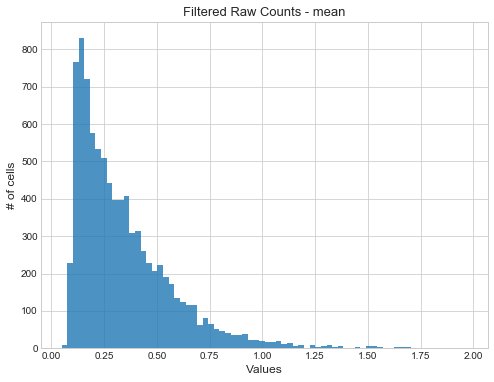

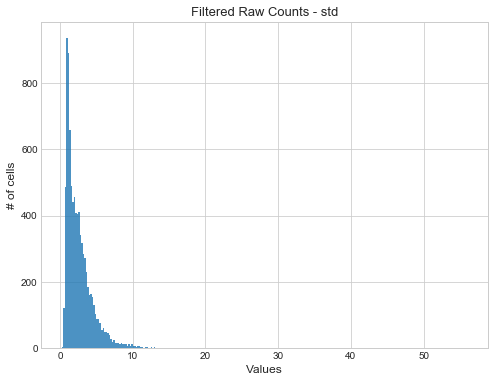

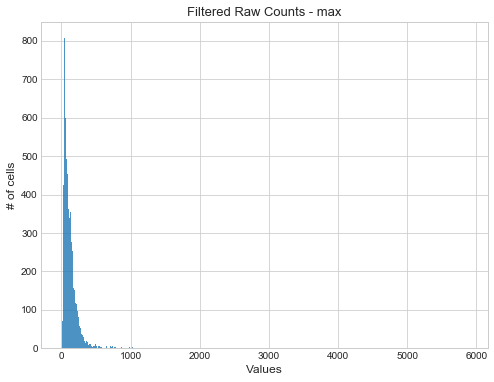

In [38]:
plot_hist(filtered_raw_counts.mean(), title = 'Filtered Raw Counts - mean', x_label = 'Values', y_label = '# of cells')
plot_hist(filtered_raw_counts.std(), title = 'Filtered Raw Counts - std', x_label = 'Values', y_label = '# of cells')
plot_hist(filtered_raw_counts.max(), title = 'Filtered Raw Counts - max', x_label = 'Values', y_label = '# of cells')

We can see that the mean RPK values are quite low, that is because in the average case, there are around 90% zeroes in the columns. We will correct that. The max values are also in quite broad range. That also need adjustments.

Before we normalize those values, let's explore something else.

When we analyze scRNA-seq data, the assessment of the quality of the data can be split into cell quality control and gene quality control. Typical quality measures for assessing the quality of a cell include the number of counts, the number of expressed genes, and the fraction of counts that are mitochondrial. A high fraction of mitochondrial reads can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell. Cells with mitochondrial fractions higher than 20% should be excluded from the analysis, as these are most likely dying cells. 

We will begin the cell quality assesment with exploring the distribution of the raw counts per cell.

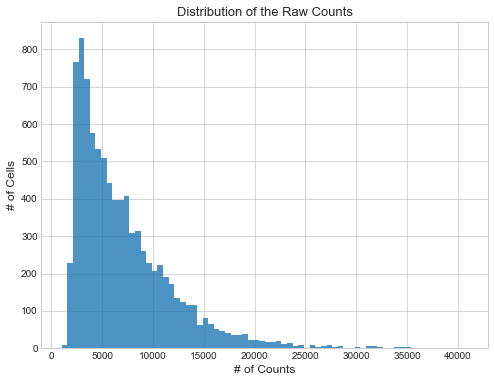

In [39]:
plot_hist(filtered_raw_counts.sum(), title = 'Distribution of the Raw Counts', x_label = '# of Counts', y_label = '# of Cells')

The above histogram shows that most of the cells have roughly 5 000 counts per cell with some extrime cases up to 35 000 counts. This is rather usual distribution for scRNA-seq data. It is interesting to see how many cells have counts below 1 000 - 1 500 counts, because these might be cellular debris found in the droplets. 

In [40]:
filtered_raw_counts.loc[:, filtered_raw_counts.sum() < 1500]

CELL BARCODES  SRR8377704-TAGACCAGTTGTACAC  SRR8377704-TCAATCTGTAGCGTGA  \
GENES                                                                     
TSPAN6                                 0.0                          0.0   
TNMD                                   0.0                          0.0   
DPM1                                   1.0                          0.0   
SCYL3                                  0.0                          0.0   
C1orf112                               0.0                          0.0   
...                                    ...                          ...   
AP001931.2                             0.0                          0.0   
C3orf36                                0.0                          0.0   
AC018809.3                             0.0                          0.0   
DUS4L-BCAP29                           0.0                          0.0   
AL355385.2                             0.0                          0.0   

CELL BARCODES  SRR8377709-AAGCAGTGGTATCAAC  SRR8377709-ATTACTCCATTTCAGG  \
GENES                                                                     
TSPAN6                            1.000000                          0.0   
TNMD                              0.000000                          0.0   
DPM1                              0.000000                          0.0   
SCYL3                             0.000000                          0.0   
C1orf112                          0.000000                          0.0   
...                                    ...                          ...   
AP001931.2                        0.333333                          0.0   
C3orf36                           0.000000                          0.0   
AC018809.3                        0.000000                          0.0   
DUS4L-BCAP29                      0.000000                          0.0   
AL355385.2                        0.000000                          0.0   

CELL BARCODES  SRR8377710-AAGCAGTGGTATCAAC  
GENES                                       
TSPAN6                                 0.0  
TNMD                                   0.0  
DPM1                                   0.0  
SCYL3                                  0.0  
C1orf112                               0.0  
...                                    ...  
AP001931.2                             0.0  
C3orf36                                0.0  
AC018809.3                             0.0  
DUS4L-BCAP29                           0.0  
AL355385.2                             0.0  

[20753 rows x 5 columns]

Only 5 cells are below the minimal treshhold. It is not worth to exclude them.

The next step in our cell quality control is to see how many genes are expressed per cell. Let's take a look.

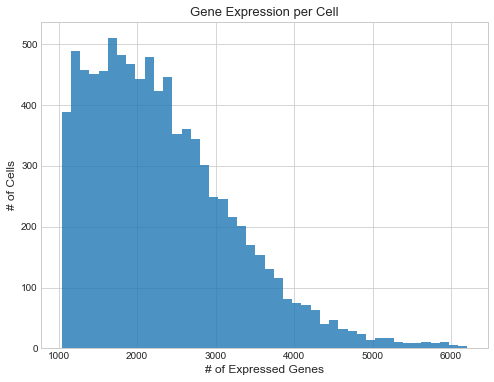

In [41]:
plot_hist(filtered_raw_counts[filtered_raw_counts > 0].count(), 
          title = 'Gene Expression per Cell', 
          x_label = '# of Expressed Genes', 
          y_label = '# of Cells')

We can see a right skewed distribution with mode expression around 2 000 genes per cell. The sharp left border of the distribution is likely due to the fact that we discard cells with expression less than 5%. Otherwise, all looks good.

Before we switch to checking the mitochondrial fraction, we can display a scatter plot of the number of counts vs. the number of expressed genes per cell, to see if there is something interesting. 

Before we do that, it is a good idea to write a function that makes scatter plot, because we will most likely need to do other scatter plots.  

In [42]:
def plot_scatter(x_axis, y_axis, figsize = (8, 6), point_size = 10, title = None, x_label = None, y_label = None):
    """
    Make scatter plot.
    """
    plt.figure(figsize = figsize)
    plt.scatter(x_axis, y_axis, s = point_size, alpha = 0.9)
    plt.title(title, fontsize = 13)
    plt.xlabel(x_label, fontsize = 12)
    plt.ylabel(y_label, fontsize = 12)
    plt.show()

Let's show this scatter plot.

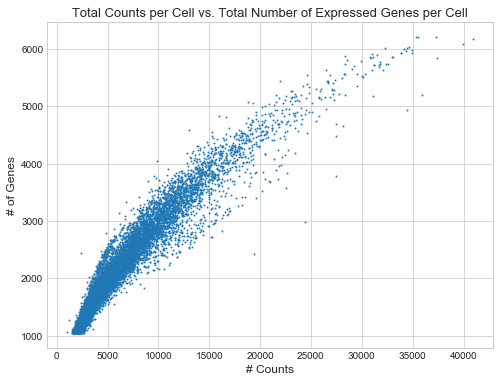

In [43]:
plot_scatter(filtered_raw_counts.sum(), 
             filtered_raw_counts[filtered_raw_counts > 0].count(),
             point_size = 1,
             title = 'Total Counts per Cell vs. Total Number of Expressed Genes per Cell',
             x_label = '# Counts',
             y_label = '# of Genes')

Everything looks normal. It seems there is positive correlation between the counts and the number of expressed genes, which was expected. 

Now, let's verify the proportions of the mitochondrial genes.

There are 37 genes in the human mitochondrial genome, as the designation of all of them begins with `MT-`. So, we could easily check if there are any. The easiest way is to see in our `genes` variable.

In [44]:
mt_gene_mask = [gene.startswith('MT-') for gene in genes]

In [45]:
sum(mt_gene_mask)

0

There are no mitochondrial genes. Most likely they have been excluded in the upstream analysis of the data.

Nonetheless, we continue with exploring the genes quality. Thus far we have tackled with cells quality. First, we can see how the genes are distributed across the cells. Let's plot a histogram of that distribution. 

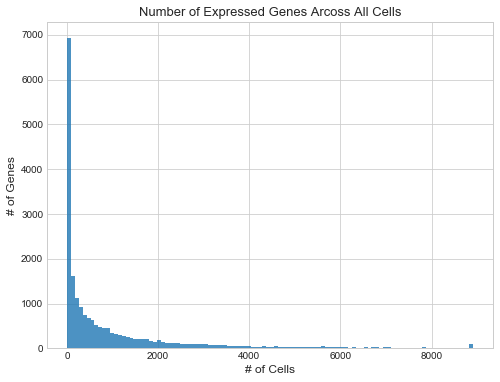

In [46]:
plot_hist(filtered_raw_counts[filtered_raw_counts > 0].count(axis = 1), 
          title = 'Number of Expressed Genes Arcoss All Cells',
          x_label = '# of Cells',
          y_label = '# of Genes')

From the histogram above we can see that there are many genes that are expressed in a tiny proprtion of the cells, and a relatively small amount of the genes are expressed in more than 1 000 cells. 

We can further "zoom in" this histogram to explore more thoroughly these low expressed genes across the cells.

In [47]:
gene_expression_across_all_cells = filtered_raw_counts[filtered_raw_counts > 0].count(axis = 1) 

In [48]:
gene_expression_across_all_cells

GENES
TSPAN6          4949
TNMD              90
DPM1            3898
SCYL3            454
C1orf112         433
                ... 
AP001931.2      1194
C3orf36            0
AC018809.3      1501
DUS4L-BCAP29    2115
AL355385.2       125
Length: 20753, dtype: int64

Let's take a look.

C:\Users\user\anaconda3\lib\site-packages\numpy\lib\histograms.py:403: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
C:\Users\user\anaconda3\lib\site-packages\numpy\lib\histograms.py:404: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
C:\Users\user\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\user\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


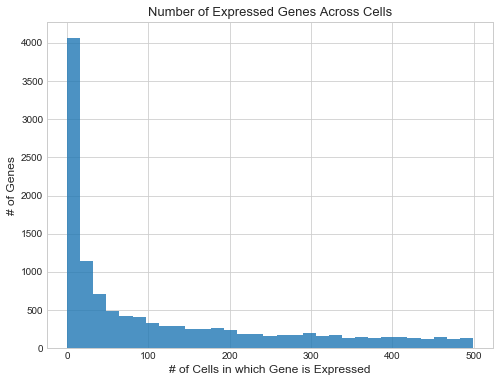

In [49]:
plot_hist(gene_expression_across_all_cells.where(gene_expression_across_all_cells < 500),
         title = 'Number of Expressed Genes Across Cells',
         x_label = '# of Cells in which Gene is Expressed',
         y_label = '# of Genes')

We observe that more than 5 000 genes are expressed in less than 50 cells. We have to filter out huge part of those genes. For that purpose, we will set a lower threshold of 1%. We have 8 900 cells, so we will set a threshold of 100 cells.

In [50]:
filtered_raw_counts = filtered_raw_counts[gene_expression_across_all_cells > 100]

In [51]:
filtered_raw_counts

CELL BARCODES  SRR8377704-GTTCTCGCACGACGAA  SRR8377704-GTTCTCGCATGCTGGC  \
GENES                                                                     
TSPAN6                                 1.0                          0.0   
DPM1                                   0.0                          0.0   
SCYL3                                  0.0                          0.0   
C1orf112                               0.0                          0.0   
CFH                                    0.0                          0.0   
...                                    ...                          ...   
AC118281.1                             0.0                          0.0   
AP001931.2                             1.5                          0.0   
AC018809.3                             0.0                          0.0   
DUS4L-BCAP29                           0.5                          0.0   
AL355385.2                             0.0                          0.0   

CELL BARCODES  SRR8377704-GTTCTCGGTTGATTGC  SRR8377704-GTTCTCGTCATATCGG  \
GENES                                                                     
TSPAN6                                 0.0                          0.0   
DPM1                                   1.0                          1.0   
SCYL3                                  0.0                          0.0   
C1orf112                               0.0                          0.0   
CFH                                    0.0                          2.0   
...                                    ...                          ...   
AC118281.1                             0.0                          0.0   
AP001931.2                             0.0                          0.0   
AC018809.3                             0.0                          0.0   
DUS4L-BCAP29                           0.0                          0.5   
AL355385.2                             0.0                          0.0   

CELL BARCODES  SRR8377704-GTTCTCGTCGTTACAG  SRR8377704-GTTCTCGTCTAGAGTC  \
GENES                                                                     
TSPAN6                                 0.0                          0.0   
DPM1                                   0.0                          0.0   
SCYL3                                  0.0                          0.0   
C1orf112                               0.0                          0.0   
CFH                                    0.0                          0.0   
...                                    ...                          ...   
AC118281.1                             0.0                          0.0   
AP001931.2                             0.5                          0.0   
AC018809.3                             0.0                          0.0   
DUS4L-BCAP29                           0.0                          0.5   
AL355385.2                             0.0                          0.0   

CELL BARCODES  SRR8377704-GTTCTCGTCTCCTATA  SRR8377704-GTTTCTAAGAGCTATA  \
GENES                                                                     
TSPAN6                                 0.0                          1.0   
DPM1                                   0.0                          2.0   
SCYL3                                  0.0                          0.0   
C1orf112                               0.0                          0.0   
CFH                                    1.0                          0.0   
...                                    ...                          ...   
AC118281.1                             0.0                          0.0   
AP001931.2                             0.0                          0.0   
AC018809.3                             0.0                          0.0   
DUS4L-BCAP29                           0.0                          0.5   
AL355385.2                             0.0                          0.0   

CELL BARCODES  SRR8377704-GTTTCTAAGGCCGAAT  SRR8377704-GTTTCTACAGATCTGT  ...  \
GENES           

We reduce the dimensions of our dataset to 13450 rows and 8907 columns. This will also decrease the memory usage, which we embrace willingly.

In [52]:
filtered_raw_counts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13450 entries, TSPAN6 to AL355385.2
Columns: 8907 entries, SRR8377704-GTTCTCGCACGACGAA to SRR8377710-ATGTGTGAGTGGTCCC
dtypes: float64(8907)
memory usage: 914.1+ MB


Now we continue with the scaling and normalization of our scRNA-seq data.

### III. Data Scaling and Normalization

As we emphasized above, the values in our dataset are reads per kilobase (RPK). This means that they are normalized for sequence length, bur are not normalized for sequencing depth. Normalization for sequencing depth is important because  it allows for legitimate comparison between cells in the dataset. 

In order to complete this normalization we have to sum up all counts for each cell, and then to divide that sum by a factor, which in our case will be 1 000 000. Thereby, we will get the "scaling factor" for each cell. Then, we have to divide each read count in the dataset by the scaling factor so that to recieve the scaled data normalized for sequencing depth in units - Transcripts Per Millions (TPM). 

Let's do that scaling.

In [53]:
scaled_counts = filtered_raw_counts.div(np.sum(filtered_raw_counts, axis = 0) / 1e6, axis = 'columns')

In [54]:
scaled_counts

CELL BARCODES  SRR8377704-GTTCTCGCACGACGAA  SRR8377704-GTTCTCGCATGCTGGC  \
GENES                                                                     
TSPAN6                          245.138095                          0.0   
DPM1                              0.000000                          0.0   
SCYL3                             0.000000                          0.0   
C1orf112                          0.000000                          0.0   
CFH                               0.000000                          0.0   
...                                    ...                          ...   
AC118281.1                        0.000000                          0.0   
AP001931.2                      367.707142                          0.0   
AC018809.3                        0.000000                          0.0   
DUS4L-BCAP29                    122.569047                          0.0   
AL355385.2                        0.000000                          0.0   

CELL BARCODES  SRR8377704-GTTCTCGGTTGATTGC  SRR8377704-GTTCTCGTCATATCGG  \
GENES                                                                     
TSPAN6                            0.000000                     0.000000   
DPM1                            219.490781                   224.895986   
SCYL3                             0.000000                     0.000000   
C1orf112                          0.000000                     0.000000   
CFH                               0.000000                   449.791972   
...                                    ...                          ...   
AC118281.1                        0.000000                     0.000000   
AP001931.2                        0.000000                     0.000000   
AC018809.3                        0.000000                     0.000000   
DUS4L-BCAP29                      0.000000                   112.447993   
AL355385.2                        0.000000                     0.000000   

CELL BARCODES  SRR8377704-GTTCTCGTCGTTACAG  SRR8377704-GTTCTCGTCTAGAGTC  \
GENES                                                                     
TSPAN6                            0.000000                     0.000000   
DPM1                              0.000000                     0.000000   
SCYL3                             0.000000                     0.000000   
C1orf112                          0.000000                     0.000000   
CFH                               0.000000                     0.000000   
...                                    ...                          ...   
AC118281.1                        0.000000                     0.000000   
AP001931.2                      118.840121                     0.000000   
AC018809.3                        0.000000                     0.000000   
DUS4L-BCAP29                      0.000000                   123.941334   
AL355385.2                        0.000000                     0.000000   

CELL BARCODES  SRR8377704-GTTCTCGTCTCCTATA  SRR8377704-GTTTCTAAGAGCTATA  \
GENES                                                                     
TSPAN6                            0.000000                   195.064859   
DPM1                              0.000000                   390.129718   
SCYL3                             0.000000                     0.000000   
C1orf112                          0.000000                     0.000000   
CFH                             267.129692                     0.000000   
...                                    ...                          ...   
AC118281.1                        0.000000                     0.000000   
AP001931.2                        0.000000                     0.000000   
AC018809.3                        0.000000                     0.000000   
DUS4L-BCAP29                      0.000000                    97.532430   
AL355385.2                        0.000000                     0.000000   

CELL BARCODES  SRR8377704-GTTTCTAAGGCCGAAT  SRR8377704-GTTTCTACAGATCTGT  ...  \
GENES           

An important consequence of this scaling is that the sum of the counts is equal for all cells. We can assure for that in the cell below. The scaled data this way enables us reasonably to compare cells with each other. 

In [55]:
np.sum(scaled_counts, axis = 0)

CELL BARCODES
SRR8377704-GTTCTCGCACGACGAA    1000000.0
SRR8377704-GTTCTCGCATGCTGGC    1000000.0
SRR8377704-GTTCTCGGTTGATTGC    1000000.0
SRR8377704-GTTCTCGTCATATCGG    1000000.0
SRR8377704-GTTCTCGTCGTTACAG    1000000.0
                                 ...    
SRR8377710-ATGGGAGGTCTCTTAT    1000000.0
SRR8377710-ATGGGAGGTGCAACTT    1000000.0
SRR8377710-ATGGGAGTCAGCTCGG    1000000.0
SRR8377710-ATGTGTGAGGCAAAGA    1000000.0
SRR8377710-ATGTGTGAGTGGTCCC    1000000.0
Length: 8907, dtype: float64

Before we continue, we will delete the `filtered_raw_counts`. 

In [56]:
del filtered_raw_counts

Now, as we have our data scaled, the next step is to log-transform them in order to complete the normalization process.
To achieve this, we will use the `numpy` function `log1p`. This function will return the natural logarithm of one plus the input data. With this offset of one, we ensure that zero counts will map to zeroes.

Let's perform this transformation.

In [57]:
normalized_counts = np.log1p(scaled_counts)

In [58]:
normalized_counts

CELL BARCODES  SRR8377704-GTTCTCGCACGACGAA  SRR8377704-GTTCTCGCATGCTGGC  \
GENES                                                                     
TSPAN6                            5.505893                          0.0   
DPM1                              0.000000                          0.0   
SCYL3                             0.000000                          0.0   
C1orf112                          0.000000                          0.0   
CFH                               0.000000                          0.0   
...                                    ...                          ...   
AC118281.1                        0.000000                          0.0   
AP001931.2                        5.910003                          0.0   
AC018809.3                        0.000000                          0.0   
DUS4L-BCAP29                      4.816800                          0.0   
AL355385.2                        0.000000                          0.0   

CELL BARCODES  SRR8377704-GTTCTCGGTTGATTGC  SRR8377704-GTTCTCGTCATATCGG  \
GENES                                                                     
TSPAN6                            0.000000                     0.000000   
DPM1                              5.395856                     5.420075   
SCYL3                             0.000000                     0.000000   
C1orf112                          0.000000                     0.000000   
CFH                               0.000000                     6.111006   
...                                    ...                          ...   
AC118281.1                        0.000000                     0.000000   
AP001931.2                        0.000000                     0.000000   
AC018809.3                        0.000000                     0.000000   
DUS4L-BCAP29                      0.000000                     4.731345   
AL355385.2                        0.000000                     0.000000   

CELL BARCODES  SRR8377704-GTTCTCGTCGTTACAG  SRR8377704-GTTCTCGTCTAGAGTC  \
GENES                                                                     
TSPAN6                            0.000000                     0.000000   
DPM1                              0.000000                     0.000000   
SCYL3                             0.000000                     0.000000   
C1orf112                          0.000000                     0.000000   
CFH                               0.000000                     0.000000   
...                                    ...                          ...   
AC118281.1                        0.000000                     0.000000   
AP001931.2                        4.786159                     0.000000   
AC018809.3                        0.000000                     0.000000   
DUS4L-BCAP29                      0.000000                     4.827844   
AL355385.2                        0.000000                     0.000000   

CELL BARCODES  SRR8377704-GTTCTCGTCTCCTATA  SRR8377704-GTTTCTAAGAGCTATA  \
GENES                                                                     
TSPAN6                            0.000000                     5.278446   
DPM1                              0.000000                     5.969039   
SCYL3                             0.000000                     0.000000   
C1orf112                          0.000000                     0.000000   
CFH                               5.591471                     0.000000   
...                                    ...                          ...   
AC118281.1                        0.000000                     0.000000   
AP001931.2                        0.000000                     0.000000   
AC018809.3                        0.000000                     0.000000   
DUS4L-BCAP29                      0.000000                     4.590386   
AL355385.2                        0.000000                     0.000000   

CELL BARCODES  SRR8377704-GTTTCTAAGGCCGAAT  SRR8377704-GTTTCTACAGATCTGT  ...  \
GENES           

We already have normalized data. Let's plot some summary statistics to see what we got. But before that, we will get rid of the scaled counts.

In [59]:
del scaled_counts

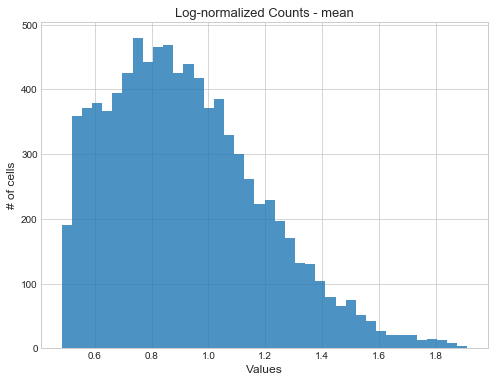

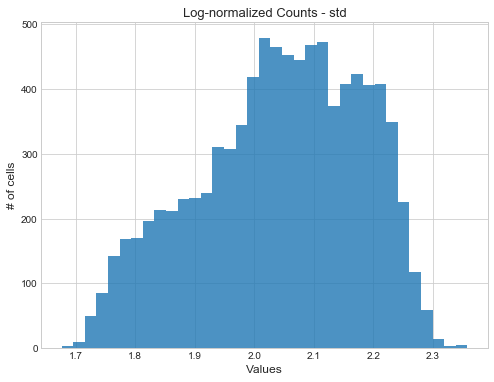

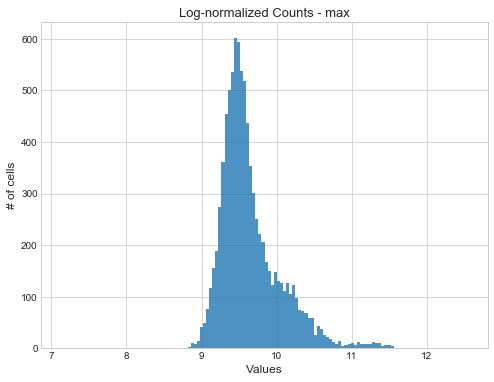

In [60]:
plot_hist(normalized_counts.mean(), title = 'Log-normalized Counts - mean', x_label = 'Values', y_label = '# of cells')
plot_hist(normalized_counts.std(), title = 'Log-normalized Counts - std', x_label = 'Values', y_label = '# of cells')
plot_hist(normalized_counts.max(), title = 'Log-normalized Counts - max', x_label = 'Values', y_label = '# of cells')

The mean and standard deviation are skewed, and whereas the majority of cells have max value around 9.5, a small cluster show up with max value of 10. Overall, everything looks fine.

Now, before we continue with the essential part of our project, we have to clarify something important. So far we have our ganes as indices of the dataframe, and cells as columns, respectively. In the context of machine learning, and in particular scikit-learn, the data have to be presented in the form `n_samples, n_features`, meaning that the samples have to be rows, and features - columns of the dataset. In our case is just the opposite. The genes are the variables, or attributes, and the cells are the samples of the dataset. The reason we have dealt with the data in this format so far is because this is the consensus representation among the biological databases. So, since `sklearn` expects the data as `n_samples, n_features`, we have to transpose the dataframe. 

As we are going to transpose the data, we will get more than 13 000 columns which will complicate the issue with the dimensionality further. During the preprocessing steps so far, we excluded cells and genes with low quality, however now we have to select genes that carry useful information for us. This feature selection will alleviate the problem with the downstream dimensionality reduction and clustering, plus this way we will get rid of of some noisy features that are inevitably present in our dataset. Informative for us genes, are genes that have high variability among the cells. These cell-to-cell variable genes carry the most significant information of the underlying biological variation in the data. Moreover, the highly variable genes are useful for visualization purposes (yet we strive for that), and also help for marker gene selection of identified subpopulation of cells. 

In order to select highly variable genes, there are several options, but we are going to choose the simplest one, by just picking the genes with most variance within the cells. 

Before we do that, let's first show a scatter plot of the mean expression of the genes vs. their variance, since this will help us get a notion of the gene variability. 

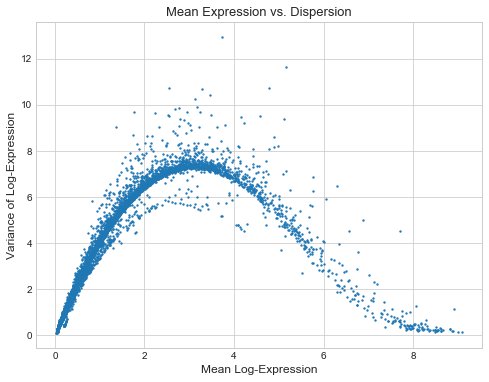

In [61]:
plot_scatter(normalized_counts.mean(axis = 1),
             normalized_counts.var(axis = 1),
             point_size = 2,
             title = 'Mean Expression vs. Dispersion',
             x_label = 'Mean Log-Expression',
             y_label = 'Variance of Log-Expression')

We can see that there is clear non-linear correlation between the mean log expression and the variance of the genes. Yet, there are also many instances of genes that escape this correlation. We strive to choose those genes that have variance significantly above the overall mean-variance trend.

Typically, between 500 and 5 000 highly variable genes are used for dimensionality reduction and clustering. We will pick 1 000 for the downstream analysis.

In [62]:
highly_variable_genes = normalized_counts.var(axis = 1).nlargest(1000)

In [63]:
highly_variable_genes

GENES
LGALS1            12.942803
RPL17-C18orf32    11.659992
IGFBP5            10.743648
FOS               10.739739
BST2              10.688480
                    ...    
SNX17              6.803253
TAGLN              6.802270
CCDC25             6.802167
CISD1              6.798419
MTX2               6.795784
Length: 1000, dtype: float64

Let's now filter our dataframe with the selected genes.

In [64]:
filtered_normalized_counts = normalized_counts[normalized_counts.index.isin(highly_variable_genes.index)]

In [65]:
filtered_normalized_counts

CELL BARCODES  SRR8377704-GTTCTCGCACGACGAA  SRR8377704-GTTCTCGCATGCTGGC  \
GENES                                                                     
TSPAN6                            5.505893                     0.000000   
DPM1                              0.000000                     0.000000   
BAD                               6.197006                     0.000000   
CD99                              0.000000                     0.000000   
NDUFAB1                           6.197006                     0.000000   
...                                    ...                          ...   
GTF2H5                            0.000000                     6.148738   
CD24                              0.000000                     0.000000   
ZNHIT3                            0.000000                     5.457724   
MARCKS                            0.000000                     6.840816   
AC132217.2                        0.000000                     4.367601   

CELL BARCODES  SRR8377704-GTTCTCGGTTGATTGC  SRR8377704-GTTCTCGTCATATCGG  \
GENES                                                                     
TSPAN6                            0.000000                     0.000000   
DPM1                              5.395856                     5.420075   
BAD                               6.086733                     5.420075   
CD99                              5.395856                     0.000000   
NDUFAB1                           6.086733                     6.111006   
...                                    ...                          ...   
GTF2H5                            6.086733                     6.111006   
CD24                              0.000000                     0.000000   
ZNHIT3                            0.000000                     0.000000   
MARCKS                            7.183829                     6.515731   
AC132217.2                        6.086733                     6.111006   

CELL BARCODES  SRR8377704-GTTCTCGTCGTTACAG  SRR8377704-GTTCTCGTCTAGAGTC  \
GENES                                                                     
TSPAN6                            0.000000                     0.000000   
DPM1                              0.000000                     0.000000   
BAD                               0.000000                     5.516982   
CD99                              0.000000                     0.000000   
NDUFAB1                           5.475125                     6.208118   
...                                    ...                          ...   
GTF2H5                            6.166175                     5.516982   
CD24                              0.000000                     0.000000   
ZNHIT3                            5.475125                     0.000000   
MARCKS                            6.166175                     0.000000   
AC132217.2                        5.879192                     0.000000   

CELL BARCODES  SRR8377704-GTTCTCGTCTCCTATA  SRR8377704-GTTTCTAAGAGCTATA  \
GENES                                                                     
TSPAN6                            0.000000                     5.278446   
DPM1                              0.000000                     5.969039   
BAD                               5.591471                     5.278446   
CD99                              0.000000                     5.278446   
NDUFAB1                           6.282751                     5.969039   
...                                    ...                          ...   
GTF2H5                            0.000000                     0.000000   
CD24                              0.000000                     0.000000   
ZNHIT3                            0.000000                     0.000000   
MARCKS                            0.000000                     5.969039   
AC132217.2                        4.902046                     0.000000   

CELL BARCODES  SRR8377704-GTTTCTAAGGCCGAAT  SRR8377704-GTTTCTACAGATCTGT  ...  \
GENES           

We can now see how significantly dropped the memory usage of the filtered dataframe. This will diminish the computational time of the dimensionality reduction and clustering algorithms.

In [66]:
filtered_normalized_counts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, TSPAN6 to AC132217.2
Columns: 8907 entries, SRR8377704-GTTCTCGCACGACGAA to SRR8377710-ATGTGTGAGTGGTCCC
dtypes: float64(8907)
memory usage: 68.0+ MB


We can convince in the variability of the genes we chose, by displying yet another scatter plot.

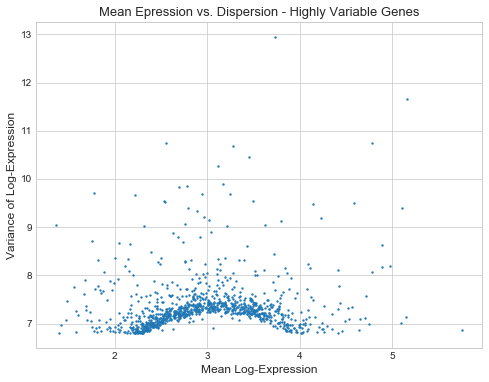

In [67]:
plot_scatter(filtered_normalized_counts.mean(axis = 1),
             filtered_normalized_counts.var(axis = 1),
             point_size = 2,
             title = 'Mean Epression vs. Dispersion - Highly Variable Genes',
             x_label = 'Mean Log-Expression',
             y_label = 'Variance of Log-Expression')

Now, it only remains to transpose our dataframe so that to be ready for applying some `sklearn` algorithms on it.

In [68]:
filtered_normalized_counts = filtered_normalized_counts.T

In [69]:
filtered_normalized_counts

GENES                          TSPAN6      DPM1       BAD      CD99   NDUFAB1  \
CELL BARCODES                                                                   
SRR8377704-GTTCTCGCACGACGAA  5.505893  0.000000  6.197006  0.000000  6.197006   
SRR8377704-GTTCTCGCATGCTGGC  0.000000  0.000000  0.000000  0.000000  0.000000   
SRR8377704-GTTCTCGGTTGATTGC  0.000000  5.395856  6.086733  5.395856  6.086733   
SRR8377704-GTTCTCGTCATATCGG  0.000000  5.420075  5.420075  0.000000  6.111006   
SRR8377704-GTTCTCGTCGTTACAG  0.000000  0.000000  0.000000  0.000000  5.475125   
...                               ...       ...       ...       ...       ...   
SRR8377710-ATGGGAGGTCTCTTAT  6.444459  0.000000  0.000000  6.444459  5.349021   
SRR8377710-ATGGGAGGTGCAACTT  5.739332  0.000000  0.000000  5.739332  0.000000   
SRR8377710-ATGGGAGTCAGCTCGG  5.565467  5.565467  0.000000  5.565467  0.000000   
SRR8377710-ATGTGTGAGGCAAAGA  5.328192  5.328192  5.328192  5.328192  5.328192   
SRR8377710-ATGTGTGAGTGGTCCC  0.000000  5.795496  0.000000  0.000000  0.000000   

GENES                          POLR2J     KMT2E    REX1BD    TMEM98   CCDC124  \
CELL BARCODES                                                                   
SRR8377704-GTTCTCGCACGACGAA  0.000000  6.197006  0.000000  6.601793  5.505893   
SRR8377704-GTTCTCGCATGCTGGC  5.457724  0.000000  0.000000  5.457724  0.000000   
SRR8377704-GTTCTCGGTTGATTGC  6.086733  6.086733  0.000000  5.395856  5.395856   
SRR8377704-GTTCTCGTCATATCGG  0.000000  5.420075  6.803043  6.515731  0.000000   
SRR8377704-GTTCTCGTCGTTACAG  0.000000  6.858272  0.000000  5.475125  0.000000   
...                               ...       ...       ...       ...       ...   
SRR8377710-ATGGGAGGTCTCTTAT  5.349021  0.000000  0.000000  5.349021  5.349021   
SRR8377710-ATGGGAGGTGCAACTT  4.142679  0.000000  6.430869  0.000000  0.000000   
SRR8377710-ATGGGAGTCAGCTCGG  5.969656  4.876141  4.876141  6.256699  4.876141   
SRR8377710-ATGTGTGAGGCAAAGA  5.328192  5.328192  5.328192  5.328192  5.328192   
SRR8377710-ATGTGTGAGTGGTCCC  0.000000  0.000000  0.000000  0.000000  0.000000   

GENES                        ...    NDUFA7  MTRNR2L2    FBXO17  AC092053.1  \
CELL BARCODES                ...                                             
SRR8377704-GTTCTCGCACGACGAA  ...  4.816800  0.000000  0.000000    5.587024   
SRR8377704-GTTCTCGCATGCTGGC  ...  0.000000  5.457724  0.000000    0.000000   
SRR8377704-GTTCTCGGTTGATTGC  ...  0.000000  6.086733  0.000000    5.395856   
SRR8377704-GTTCTCGTCATATCGG  ...  0.000000  6.803043  0.000000    0.000000   
SRR8377704-GTTCTCGTCGTTACAG  ...  4.786159  0.000000  0.000000    5.475125   
...                          ...       ...       ...       ...         ...   
SRR8377710-ATGGGAGGTCTCTTAT  ...  5.349021  6.039789  0.000000    0.000000   
SRR8377710-ATGGGAGGTGCAACTT  ...  5.049396  6.835797  6.430869    0.000000   
SRR8377710-ATGGGAGTCAGCTCGG  ...  4.190591  5.565467  4.876141    0.000000   
SRR8377710-ATGTGTGAGGCAAAGA  ...  5.328192  6.710840  0.000000    5.416085   
SRR8377710-ATGTGTGAGTGGTCCC  ...  5.795496  5.795496  6.892078    0.000000   

GENES                            CCL5    GTF2H5      CD24    ZNHIT3    MARCKS  \
CELL BARCODES                                                                   
SRR8377704-GTTCTCGCACGACGAA  6.197006  0.000000  0.000000  0.000000  0.000000   
SRR8377704-GTTCTCGCATGCTGGC  0.000000  6.148738  0.000000  5.457724  6.840816   
SRR8377704-GTTCTCGGTTGATTGC  6.491440  6.086733  0.000000  0.000000  7.183829   
SRR8377704-GTTCTCGTCATATCGG  0.000000  6.111006  0.000000  0.000000  6.515731   
SRR8377704-GTTCTCGTCGTTACAG  6.570940  6.166175  0.000000  5.475125  6.166175   
...                               ...       ...       ...       ...       ...   
SRR8377710-ATGGGAGGTCTCTTAT  5.349021  5.349021  0.000000  0.000000  0.000000   
SRR8377710-ATGGGAGGTGCAACTT  0.000000  5.739332  0.000000  0.000000  0.000000   
SRR8377710-ATGGGAGTCAGCTCGG  0.000000  0.000000  7.864601  4.876141

8907 rows x 1000 columns. It is better now.

### IV. Comparison between Different Dimensionality Reduction Algorithms for Visualization of scRNA-seq Data

Visualizing scRNA-seq data is the process of projecting or embedding a high-dimensional matrix of cells and genes into a two or three coordinates such that every cell is meaningfully represented in a two- or three-dimensional graph. The visualization of scRNA-seq data is an active area of research and each method defines "meaningful" in its own way. Thus, it is a good idea to look at several visualization techniques and decide which one best represents the aspect of the data that is being investigated.

Overall, t-SNE visualizations have been very popular among the scientific community, however the recent UMAP algorithm has been shown to better represent the topology of the data.

Note that we did not scale the genes to have zero mean and unit variance. A lack of rescaling is equivalent to giving genes with a higher mean expression a higher weight in dimensionality reduction (despite correcting for mean offsets in PCA, due to the mean-variance relationship). Nevertheless, rescaling highly variable gene expression is also common, and many researchers suggest that such scaling is at least not detrimental to downstream scRNA-seq analysis. However, we will preserve this weighting based on the mean expression as being a biologically relevant signal.

### 1. Dimensionality Reduction and Visualization with PCA

As we mentioned above, dimensionality reduction is very useful, and it is employed indispensably in any scRNA-seq experiment to summarize and visualize relationships between cells in the low-dimensional space. 

Principal Component Analysis (PCA) is the most popular linear dimension reduction technique that projects the high-dimensional data into linearly orthogonal low-dimensional vector space through variance maximization. Due to its efficiency and conceptual simplicity, PCA is widely applied to scRNA-seq data for both dimension reduction and visualization. 

In scikit-learn, PCA is implemented as a transformer object that learns components in its `fit` method, and can be used on new data to project it on these components. Principal Components (PCs) can be computed either by using eigenvalue decomposition (EVD) or singular value decomposition (SVD). In the scikit-learn implementation, PCs are worked out by SVD of the data to project it to a lower dimensional space. 

In a nutshell, SVD decomposes the original data matrix $A_{n_x m}$ into three other matrices $A= U\Sigma V^T$, where both $U_{n_x n}$ and $V_{m_x m}$ are orthogonal and $\Sigma_{n_x m}$ is diagonal matrix. Calculating the SVD consists of finding the eigenvalues and eigenvectors of $AA^T$ and $A^TA$. The eigenvectors of $A^TA$ make up the columns of $V$, while the eigenvectors of $AA^T$  make up the columns of $U$. Also, the singular values in $\Sigma$ are square roots of eigenvalues from $AA^T$ and $A^TA$. The singular values are the diagonal entries of the $\Sigma$ matrix and are arranged in descending order. In the scikit-learn implemenation the input data is first centered to zero mean - this is the so-called mean-centered data (quite unexpectedly), on which SVD is applied. The most important principal components are just the leading eigenvectors in $U$, which are determined and ordered by importance by the singular values (eigenvalues) of the $\Sigma$ matrix, so that the first principal component explains the first most variance in the data, the second PC explains the second most variance, and so on and so forth.

Let's now put aside the explanations about PCA, and do some PCA. First we have to create a PCA object. We are choosing to keep the first 50 principal components.

In [70]:
pca = PCA(n_components = 50, random_state = 42)

Next we have to call the `fit` method on the filtered normalized data. This is where the internal parametars of the data are learnt.

In [71]:
pca.fit(filtered_normalized_counts)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=42,
    svd_solver='auto', tol=0.0, whiten=False)

Now we have to transform the data.

In [72]:
pca_data = pca.transform(filtered_normalized_counts)

In [73]:
pca_data

array([[ 6.93517455e+00,  3.18433687e+01, -9.62101502e+00, ...,
        -2.32139705e+00, -1.82174324e+00,  3.35087245e+00],
       [ 2.30449578e+01, -8.66698706e+00, -1.30523873e+01, ...,
        -4.50367764e+00, -6.51628266e-01, -5.14110511e-01],
       [ 5.74111578e-04, -9.13030043e+00, -1.67247262e+01, ...,
         4.21985332e-01,  1.63608229e+00, -3.37018743e+00],
       ...,
       [-2.11263603e+01,  5.04168440e+00,  1.79697481e+01, ...,
        -4.43512861e+00, -4.38403264e+00,  2.98104247e+00],
       [ 1.24030704e+00, -5.15167745e+00, -2.04361169e+01, ...,
        -2.68409129e+00,  2.12306986e+00,  8.13465520e-02],
       [ 1.88317923e+01,  3.06807083e+01, -1.57756890e+01, ...,
        -4.87303019e+00, -8.15398329e-02, -1.62622441e-01]])

We can assure that our transformed data are already with the desired dimensions.

In [74]:
pca_data.shape

(8907, 50)

We can display the eigenvalues and eigenvectors of the kept principal components, however those would not be very interesting for us. Better idea is to show the `explained_variance_ratio_`, as this ratio reflect the percentage of the explained variance by each PC in descending order.

In [75]:
pca.explained_variance_ratio_

array([0.0874513 , 0.02861582, 0.02386909, 0.01187764, 0.00890341,
       0.00744631, 0.00499248, 0.00436172, 0.00365454, 0.0032327 ,
       0.00306873, 0.00283325, 0.00253001, 0.00243199, 0.00229909,
       0.00218136, 0.00207768, 0.0019982 , 0.00193002, 0.00187696,
       0.00182033, 0.0017552 , 0.00173474, 0.0017236 , 0.00165671,
       0.00161997, 0.00155912, 0.00154794, 0.00154018, 0.00152194,
       0.00148365, 0.0014674 , 0.00145428, 0.00144031, 0.00143149,
       0.00142334, 0.00141618, 0.00140868, 0.00140042, 0.00138635,
       0.00137845, 0.00137213, 0.00136174, 0.00135763, 0.00134939,
       0.00134453, 0.00134023, 0.00133683, 0.00132968, 0.00132616])

Well, the results we see are not very satisfying because the first two principal components explain only 12% of the variation in the data. As we are going to use these two principal components to visualize the data later, the representation which we will get, will not be very information about the overall represantation of the data. But that is normal, yet we shrunk 1 000 genes to only 50 PCs, the first two of which account for 12% of the data. 

We can also see the cumulative sum of the principal components we chose to keep.

In [76]:
np.cumsum(pca.explained_variance_ratio_)

array([0.0874513 , 0.11606711, 0.1399362 , 0.15181384, 0.16071725,
       0.16816355, 0.17315604, 0.17751775, 0.18117229, 0.18440499,
       0.18747372, 0.19030697, 0.19283697, 0.19526896, 0.19756805,
       0.19974941, 0.20182709, 0.2038253 , 0.20575531, 0.20763227,
       0.2094526 , 0.2112078 , 0.21294254, 0.21466615, 0.21632286,
       0.21794283, 0.21950195, 0.2210499 , 0.22259008, 0.22411202,
       0.22559567, 0.22706307, 0.22851735, 0.22995766, 0.23138915,
       0.23281249, 0.23422867, 0.23563735, 0.23703777, 0.23842412,
       0.23980257, 0.2411747 , 0.24253644, 0.24389408, 0.24524346,
       0.24658799, 0.24792822, 0.24926505, 0.25059473, 0.25192089])

Only 1/4 of the data variance is kept by the first 50 PCs. Generally, that is quite bad proportion. However, we should explain something about the gene expression. In principle, the gene expression is stochastic occurrence with a lot of intrinsic noise, and if we add the technical noise which is inevitably present in any scRNA-seq experiment, seeking for high percentage of explanation of the variance in the data may not be a good approach to it. Typically, one strive for about 95% explanation by the PCs, however in our case 70-80% would be reasonable percentage. Nonetheless, we will not go for choosing more components, but rather we will continue to use these 50 PCs in all downstream clustering and visualization algorithms. In order to explain 70% of the selected 1 000 highly variable genes, we have to use more than 500 PCs, which in our case may not be so justified in terms of computational time because some of the algorithms we are going to use are quite clunky.

As we clarified that, let's plot the change in the `explained_variance_ratio_` to get a better idea about how these ratios changes with the principal components.

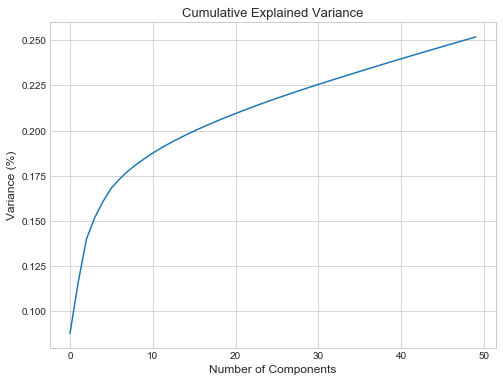

In [77]:
plt.figure(figsize = (8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative Explained Variance', fontsize = 13)
plt.xlabel('Number of Components', fontsize = 12)
plt.ylabel('Variance (%)', fontsize = 12)
plt.show()

We can even do it better. We can display the so-called scree plot of the first, let's say 20 PCs to get a better understanding about the dynamic of change in the explained variance by the PCs.

We should first calculate the percentage of variation that each principal component accounts for.

In [78]:
percentage_variation = np.round(pca.explained_variance_ratio_ * 100, decimals = 1)

A scree plot is just a bar chart that shows the dynamic of change in the explained variance by each principal components. 

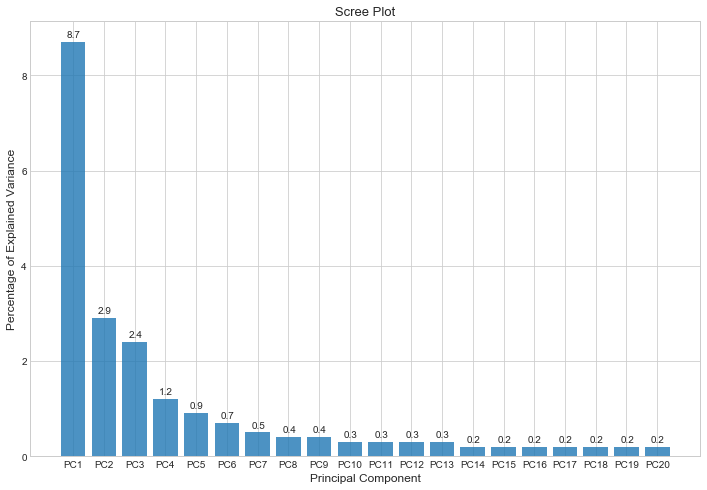

In [79]:
plt.figure(figsize = (12, 8))

# assign bar plot to a variable so that their attributes can be accessed
bars = plt.bar(x = range(1, 21), 
               height = percentage_variation[:20], 
               tick_label = ['PC' + str(i) for i in range(1, 21)], 
               alpha = 0.8)

# access bar attributes to annotate each PC explained variance in %
for bar in bars:
    height = bar.get_height()
    plt.text(x = bar.get_x() + .2, 
             y = height + .1, 
             s = f'{height}')
    
plt.title('Scree Plot', fontsize = 13)
plt.xlabel('Principal Component', fontsize = 12)
plt.ylabel('Percentage of Explained Variance', fontsize = 12)
plt.show()

We can see how sharply drops the explained variance in the data with increasing the number of PCs. We are observing almost 10-fold decrease in the magnitude of the explain variance between the 1st and 5th PC, and nearly 30-fold between the 1st and 10th PC. This abrupt decline in the explained variance illustrate why it is not reasonable to keep many principal components.

Now, we can try to visualize the original data by using the first two principal components. We already emphasized that these components account for barely 12% of the data, even if we pick the 3rd component, in case we do a 3D graph, we would be able to represent 15% of the original data. So, we are going to stick to the simpler 2D graph.

In order to do that graph, we should first create a `pd.DataFrame` with the first two PCs.

In [80]:
pca_dataframe = pd.DataFrame(pca_data[:, :2], columns = ['PC1','PC2'])

In [81]:
pca_dataframe

PC1        PC2
0      6.935175  31.843369
1     23.044958  -8.666987
2      0.000574  -9.130300
3     22.145124  -7.698668
4     26.944972  -3.848192
...         ...        ...
8902   1.609083  29.836873
8903  22.207016  32.843174
8904 -21.126360   5.041684
8905   1.240307  -5.151677
8906  18.831792  30.680708

[8907 rows x 2 columns]

We can now use this dataframe to create a scatter plot of the PC1 and PC2.

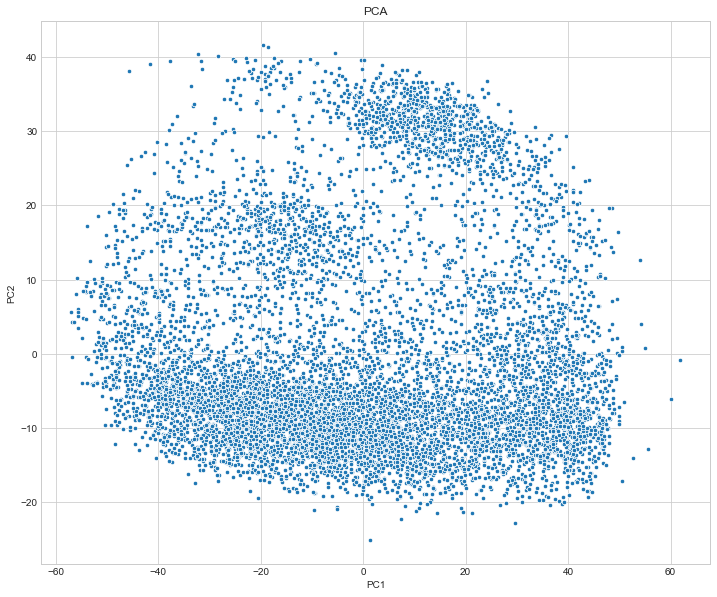

In [82]:
plt.figure(figsize = (12, 10))
sns.scatterplot(data = pca_dataframe, x = 'PC1', y = 'PC2', s = 20).set_title('PCA')
plt.show()

And we got this mess of dots, each representing the relative position of each single cell from the original high-dimensional data based on the first two principal components. It is obvious that this plot does not carry any meaningful information to us, because first - we can not see any clearly separable clusters in the graph, and second - sine we don't have "ground truth" about how many different cell types (clusters) are in our data we can not label them. Therefore, we should do something about these issues. 

As we do not have provided labels about the cell types in our data, we should make our own. This is only possible by using different clustering techniques. So far the most used clustering algorithms for scRNA-seq data are K-means Clustering, Hierarchical Clustering, and Graph-based Clustering methods. Density-based clustering techniques like DBSCAN are proven not to work with scRNA-seq data. 

In this project we are going to use k-means and hierarchical clustering, since these are the two most commonly used algorithms for clustering scRNA-seq data. 

K-means is a prototype-based clustering algorithm that aims to cluster data by trying to separate observations in $n$ groups of equal variance, minimizing a criterion known as _inertia_ or within-cluster sum-of-squares. The inertia can be considered as a measure of how internally coherent clusters are. Generally, the algorithm walks through the following steps:

1. The first step chooses the initial $k$ centroids (chooses the number of clusters).

2. The algorithm randomly select $k$ distinct data points for initial centroids.

3. Assigns each observation to its nearest centroid by using a distance metric and calculate the mean of each cluster.

4. Moves the centroinds to the calculated mean of the clusters.

5. Repeats step 3 and 4 until convergence. In other words, it repeats until the centroids do not move significantly.

Main limitation of K-means is that it requires the number of clusters to be specified, and in many casas this number is unknown $apriori$.

There are two main heuristic methods used to approximate the number of clusters - the elbow method and the silhouette method. We are going to use both methods to estimate that number.

The basic idea behind k-means is to define clusters such that the total within-cluster sum-of-squares (the inertia) is minimized. The inertia measures the compactness of the clustering and we want it to be as small as possible. Thus, we can perform k-means for different values of $k$, for instance by varying $k$ from 2 to 10. Then for each cluster we can calculate the the total within-cluster sum of square (inertia) and plot a curve of the worked out values to the number of clusters $k$. The location of a bend (elbow) in the plot is generally considered as an indicator of the appropriate number of clusters. 

Let's do this plot.

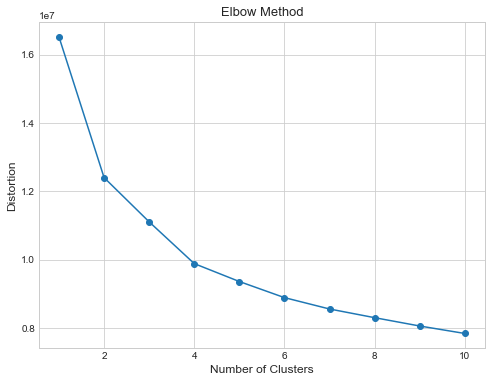

In [83]:
distortions = []

for i in range(1, 11):
    k_means = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    k_means.fit(pca_data)
    distortions.append(k_means.inertia_)

plt.figure(figsize = (8, 6))
plt.plot(range(1, 11), distortions, marker = 'o')
plt.title('Elbow Method', fontsize = 13)
plt.xlabel('Number of Clusters', fontsize = 12)
plt.ylabel('Distortion', fontsize = 12)
plt.show()

Well, looking at the bend of the curve we can estimate that at 2, or 3, perhaps 4 clusters, the distortion is greatest, i.e the inertia drops most abruptly. However, we assume that relying only on this method is a bad idea. So, we will employ the second graphical metod for estimation of the number of clusters - the silhouette method. 

In short, the silhouette approach measures the quality of a clustering. That is, it determines how well each sample lies within its cluster. It is measured within the range (-1, 1). Silhouette coefficients close to +1 suggest the sample is distant from the neighboring clusters. A value of 0 means that the sample is between two adjacent clusters or very close to the decision boundary, and negative indicate wrong cluster assignment for that sample. 

We can compute the average silhouette coefficients of all samples by using the `silhouette_score` function for $k$-number of clusters.

Let's iterate from 2 to 20 $k$ to see what scores we will get.

In [84]:
for n_clusters in range(2, 21):
    
    kmeans = KMeans(n_clusters = n_clusters, init = 'k-means++', random_state = 42)
    kmeans_labels = kmeans.fit_predict(pca_data)
    
    # compute the average silhouette score for all samples
    silhouette_average = silhouette_score(pca_data, kmeans_labels)
    
    print(f'For n_clusters = {n_clusters}, The average silhouette_score is: {silhouette_average}')

For n_clusters = 2, The average silhouette_score is: 0.21837029575233172
For n_clusters = 3, The average silhouette_score is: 0.16882472177842636
For n_clusters = 4, The average silhouette_score is: 0.18533595491686622
For n_clusters = 5, The average silhouette_score is: 0.1765694132282921
For n_clusters = 6, The average silhouette_score is: 0.16116283785366825
For n_clusters = 7, The average silhouette_score is: 0.15039390405410266
For n_clusters = 8, The average silhouette_score is: 0.14236749830710446
For n_clusters = 9, The average silhouette_score is: 0.13797577224811156
For n_clusters = 10, The average silhouette_score is: 0.13599735985050632
For n_clusters = 11, The average silhouette_score is: 0.12021707539133038
For n_clusters = 12, The average silhouette_score is: 0.12656201301272185
For n_clusters = 13, The average silhouette_score is: 0.12791437825514726
For n_clusters = 14, The average silhouette_score is: 0.12771688900106792
For n_clusters = 15, The average silhouette_sco

Looking at the silhouette scores we can evaluate that 4 clusters may be an optimal desicion for choosing $k$. However, we can do it better than just looking at the average silhouette scores. We can assess the quality of each cluster visually by displaying a silhouette plot. This plot will allow us to visually interpret how close each point in one cluster is to points in neighboring clusters, and thus to assess the parameters of the clustering better.

We will iterate from 3 to 6 $k$-number of clusters (because these look most promising based on the average silhouette scores), then we will compute the average silhouette coefficient for each sample by using the `silhouette_samples` function. Next we will aggregate these coefficients for samples belonging to $k$-th cluster, and finally we will work out the respective sizes of the clusters and will plot them on a graph.

Let's explore these clusters visually.

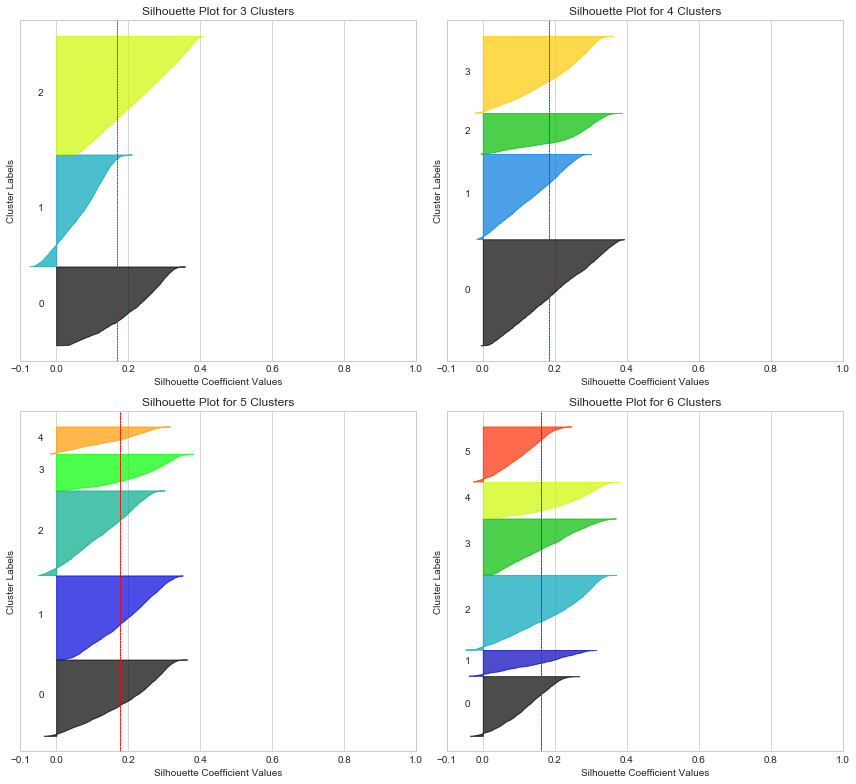

In [85]:
plt.figure(figsize = (12, 11))

n_clusters = [3, 4, 5, 6]

for index, cluster_value in enumerate(n_clusters):
    
    kmeans = KMeans(n_clusters = cluster_value, init = 'k-means++', random_state = 42)
    kmeans_labels = kmeans.fit_predict(pca_data)
    
    # compute the average silhouette score for all sample
    silhouette_average = silhouette_score(pca_data, kmeans_labels)
    
    # compute the silhouette score for each sample
    sample_silhouette_score = silhouette_samples(pca_data, kmeans_labels)

    plt.subplot(2, 2, index + 1)
    
    # set the initial y-low border
    y_lower = 10
    
    for i in range(cluster_value):
        
        # aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_score[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # compute cluster sizes
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        
        # set the y-up border
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / cluster_value)
        
        plt.fill_betweenx(y = np.arange(y_lower, y_upper), x1 = 0, x2 = ith_cluster_silhouette_values,
                          facecolor = color, edgecolor = color, alpha = 0.7)

        # label the silhouette plots with their cluster numbers
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # compute the new y_lower border for the next plot
        y_lower = y_upper + 10  
        
        # draw vertical line for the average silhouette score
        plt.axvline(x = silhouette_average, color = 'red', linestyle = '--', linewidth = .5)
   
        plt.title(f'Silhouette Plot for {cluster_value} Clusters', fontsize = 12)
        plt.xlabel('Silhouette Coefficient Values', fontsize = 10)
        plt.ylabel('Cluster Labels', fontsize = 10)
        plt.xlim([-0.1, 1])
        plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.yticks([])
        plt.tight_layout()
    
plt.show()

Looking at the silhouette plots we can really estimate that $k$ equal 4 would be an optimal decision, because these clusters look most consistent (with some equal shape and size), and almost without wrongly assined samples to each cluster. It is also important to look at how rounded each cluster is, because this is a good indicator about the quality of the corresponding cluster. On the other hand, the silhouette plots with 3 and 5 clusters do not look very reliable because of the many wrongly assigned samples to the plot with 3 clusters, and due to the unequal sizes of the clusters at the plot with 5 clusters. The silhouette plot with 6 clusters also has wrongly assigned samples, however it looks in a way more consistent than those with 3 and 5 clusters. 

As we mentioned above, the elbow method and the silhouette method are heuristic graphical methods for estimation of the  correct number of clusters for algorithms like k-means. Decision taken upon them is justified, however we should also refer to some domain knowledge about our data. It is very unlikely the entire population of cells under investigation to be homogeneous. Yes, the cells are described as being podocytes, nevertheless, presumably there are many different subpopulation among this cell type. Yet, a major reason one to carry out scRNA-seq experiment is to uncover different subpopulation, and finding developmental trajectories based on the identification of steady marker genes in each subpopulation. Therefore, we are going to search for 6 clusters (we can even choose larger number), as thus we are more likely to find different subpopulation in our dataset.

So, let's instantiate a k-means object with `n_clusters=6`, and `init=k-means++` as a method of initialization of the centroinds of each cluster.

In [86]:
k_means = KMeans(n_clusters = 6, init = 'k-means++', random_state = 42)

We can now learn the internal parameters of the data by fitting our `pca_data`.

In [87]:
k_means.fit(pca_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

By using the `predict` method we can get the closest cluster each cell in our pca data belongs to.

In [88]:
cell_labels_kmeans = k_means.predict(pca_data)

In [89]:
cell_labels_kmeans

array([4, 0, 0, ..., 1, 0, 4])

Now, we can use the already obtained cluster labels to visualize the pca data. Before that, however, we will write a function that construct a `pd.DataFrame` from pca data and labels genarated from clustering algorithm. 

In [90]:
def construct_2d_dataframe_with_labels(data, column_names: list, labels, labels_name: list):
    """
    Design a pandas DataFrame adapted for seaborn scatterplot function.
    """
    return pd.DataFrame(data = data, columns = column_names).join(pd.DataFrame(data = labels, columns = labels_name))

Now, let's use that function to create a dataframe adapted for the seaborn `scaterplot` function, which function we will use to visualize our data from now onwards.

In [91]:
pca_dataframe = construct_2d_dataframe_with_labels(data = pca_data[:, :2], 
                                              column_names = ['PC1','PC2'],
                                              labels = cell_labels_kmeans,
                                              labels_name = ['Cell Labels KM'])

In [92]:
pca_dataframe

PC1        PC2  Cell Labels KM
0      6.935175  31.843369               4
1     23.044958  -8.666987               0
2      0.000574  -9.130300               0
3     22.145124  -7.698668               0
4     26.944972  -3.848192               0
...         ...        ...             ...
8902   1.609083  29.836873               4
8903  22.207016  32.843174               4
8904 -21.126360   5.041684               1
8905   1.240307  -5.151677               0
8906  18.831792  30.680708               4

[8907 rows x 3 columns]

Let's now use this dataframe to visualize the already labeled first two principal components.

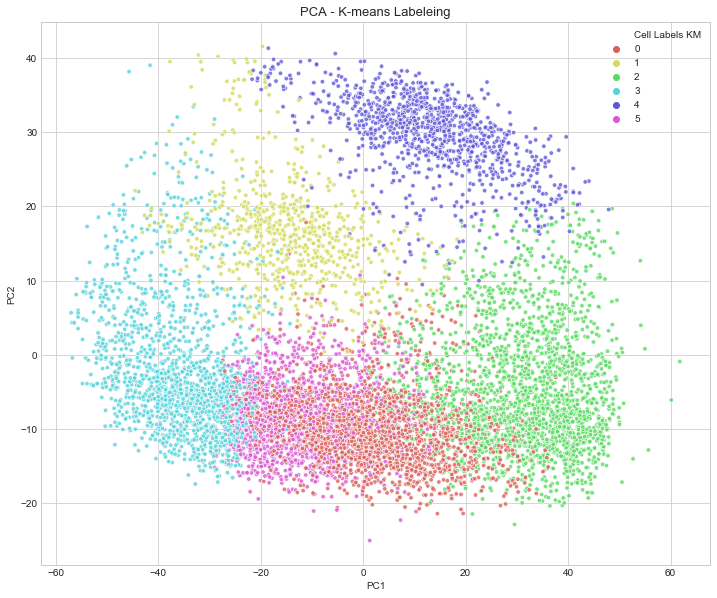

In [93]:
plt.figure(figsize = (12, 10))
sns.scatterplot(data = pca_dataframe, 
                x = 'PC1', 
                y = 'PC2', 
                hue = 'Cell Labels KM',
                palette = sns.color_palette("hls", 6),
                alpha = 0.8,
                legend = 'full',
                s = 20).set_title('PCA - K-means Labeleing', fontsize = 13)
plt.show()

And we obtained the same 'blob' of dots as above, this time, however, colored. As it became clear, PCA is not capable to generate sufficiently separable groups of cells so that we can observe clear trend in the data. Perhaps, the dark blue cluster is the most clearly distinguishable, however, that is not enough to make some conclusions about our data, but we should test some other techniques, which would be more suitable for scRNA-seq data. t-SNE and UMAP are very reliable candidates for that objective.

Before we proceed to employing them on work, however, we will use hierarchical clustering on our pca generated data, to see whether there is some substantial difference between the labels produced from k-means and hierarchical clustering, or the clustering is consistent.

Hierarchical clustering is a general family of clustering algorithms that build nested clusters by merging or splitting the clusters successively. We will use the scikit-learn `AgglomerativeClustering` that performs a hierarchical clustering using a bottom up approach - each observation starts in its own cluster, and clusters are successively merged together. We can choose between different distance metrics for determining of similarity between the observations, like - "euclidean", "manhattan", "cosine", or "precomputed", and distinct lenkage methods, such as - "ward", "complete", "average", or "single". The distance metrics very often are choosen arbitrarily. However, the preferable choice for scRNA-seq data is the "euclidean" distance, so we will stick to it. In addition, the choice of linkage method also has effect on the clustering. The linkage criterion determines the metric used for comparing and merging distinct clusters or set of observations. We will choose "ward", which minimizes the sum of squared differences (variance) within all clusters. As with distance metrics, the linkage is also arbitrarily chosen and the effect of it can be observed when the clusters are shown as a heatmap or dendrogram. 

Now, let's create an `AgglomerativeClustering` object with the defined parameters.

In [94]:
agglomerative_clustering = AgglomerativeClustering(n_clusters = 6, affinity = 'euclidean', linkage = 'ward')

We can now fit the pca data.

In [95]:
agglomerative_clustering.fit(pca_data)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=6)

...and take the labels.

In [96]:
agglomerative_labels = agglomerative_clustering.labels_

In [97]:
agglomerative_labels

array([0, 1, 2, ..., 2, 1, 4], dtype=int64)

Let's now visualize these labels.

First we should construct a dataframe with the labels and the first two principal components.

In [98]:
pca_dataframe_ac = construct_2d_dataframe_with_labels(data = pca_data[:, :2], 
                                              column_names = ['PC1','PC2'],
                                              labels = agglomerative_labels,
                                              labels_name = ['Cell Labels AC'])

In [99]:
pca_dataframe_ac

PC1        PC2  Cell Labels AC
0      6.935175  31.843369               0
1     23.044958  -8.666987               1
2      0.000574  -9.130300               2
3     22.145124  -7.698668               1
4     26.944972  -3.848192               1
...         ...        ...             ...
8902   1.609083  29.836873               4
8903  22.207016  32.843174               4
8904 -21.126360   5.041684               2
8905   1.240307  -5.151677               1
8906  18.831792  30.680708               4

[8907 rows x 3 columns]

Let's use the dataframe to see what we will get.

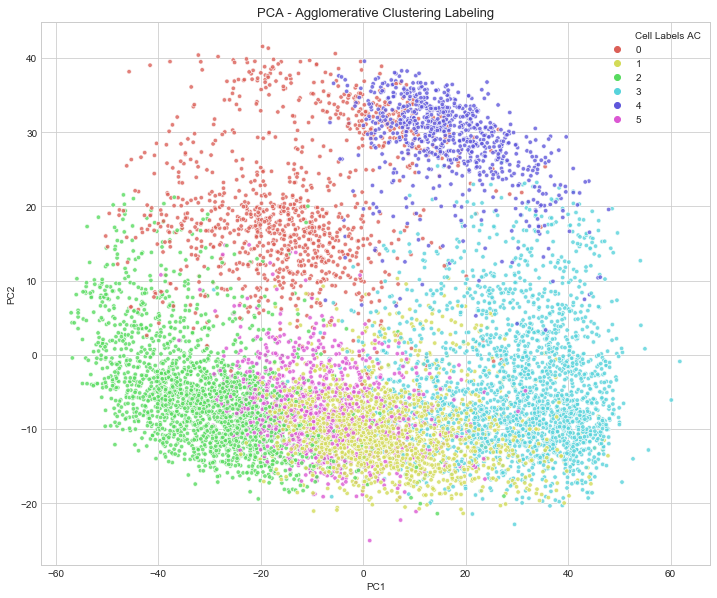

In [100]:
plt.figure(figsize = (12, 10))
sns.scatterplot(data = pca_dataframe_ac, 
                x = 'PC1', 
                y = 'PC2', 
                hue = 'Cell Labels AC',
                palette = sns.color_palette("hls", 6),
                alpha = 0.8,
                legend = 'full',
                s = 20).set_title('PCA - Agglomerative Clustering Labeling', fontsize = 13)
plt.show()

Well, visually we got something very similar to the labels provided by k-means. However, we should make some attempts to evaluate computationally both clusterings. Evaluating the performans of unsupervised clustering algorithms is not as trivial task as evaluating the supervised algorithms. Fortunately, there is a function in scikit-learn - `adjusted_rand_score` that mesures the similarity (agreement) of two clustering algorithms on an overlapping dataset. This function measures if geven clustering defines separation of the data similar to some ground truth. Nevertheless, `adjusted_rand_score` can be used to compare the overall separation of the data defined by two clustering algorithms since it is symmetric function (adjusted_rand_score(a, b) == adjusted_rand_score(b, a)), and thus we are not obligated to know the "ground truth". Thereby, we can just compare the two clusterings. Plus, both scores in the function are adjusted for chance which means that 2 random clusterings will likely have a score close to 0.0. In addition, the scores range between (-1.0, 1.0), as 1.0 stands for perfect match. 

Let's use this function to see how much agreement is there between k-means and hierarchical clustering on our pca data.

In [101]:
print(f'Adjusted Rand Index = {adjusted_rand_score(kmeans_labels, agglomerative_labels):.2f}')

Adjusted Rand Index = 0.67


It is not bad, given that we could receive negative result. That imply consistency between both algorithms on our data, meaning that the clustering is robust. 

Before we switch to evaluating the visualization capabilities of t-SNE on our scRNA-seq data, we can look at the loading scores for principal component 1 to determine which genes had the largest infuence on separating the data along the x-axis. 

We will start by creating a `pd.Series` with the loading scores in PC1.

In [102]:
loading_scores = pd.Series(pca.components_[0], index = filtered_normalized_counts.columns)

Now we have to sort the loading scores based on their absolute values.

In [103]:
sorted_loading_scores = loading_scores.abs().sort_values(ascending = False)

Let's get the gene names of the top 20 loading scores participating in the partitioning of the PC1. 

In [104]:
top_20_genes = sorted_loading_scores[: 20].index.values

Finally we can see the top 20 gene names with their corresponding loading scores. 

In [105]:
loading_scores[top_20_genes]

GENES
CCNG1       -0.057207
HMGA2       -0.052642
SMS         -0.051750
MLLT11      -0.051494
RPL10P9      0.050904
STRAP       -0.050750
PGAM1       -0.050726
CD99        -0.048104
RPS2P7       0.047799
MACROH2A2   -0.047301
VDAC3       -0.047196
EIF2S3      -0.047175
FSCN1       -0.046882
KPNA2       -0.046842
MAGED1      -0.046829
LDHA        -0.046573
MAPRE1      -0.046434
SDCBP       -0.046385
RBBP7       -0.046242
ATP1B3      -0.045995
dtype: float64

Well, searching on the internet we found that the genes we got are ubiquitously expressed in many body tissues and participate at important cell processes such as - regulation of the cell cycle (CCNG1), maintaining the chromosome architecture (HMGA2), or take part in the glycolytic pathway (PGAM1). 

Detailed examination of the function of these genes is not intended for this project. We just wanted to demonstrate that based on the loading scores in the first ranked eigenvector (PC1) we can gain important information about our data. In fact, there are other methods for searching of marker genes in given population or subpopulations of cells, however that is not included in the goals of the project, as well.

### 2. Dimensionality Reduction and Visualization with t-SNE

Before we dive into the specificity of t-SNE, let's first clarify something about the dimensionality reduction algorithms. In reality, there are only two techniques for dimension reduction - projection (or matrix factorization) and manifold (neighbour graph) learning. Matrix factorization techniques like Principal Component Analysis, Non-negative Matrix Factorization, and Latent Dirichlet Allocation are linear dimension reduction algorithms that try to project the data into a lower-dimensional space by applying some sort of matrix decomposition. These methods can be powerful when it comes to finding linear structure in the data. However, that is not always the case. By contrast, neighbour graph techniques, such as - Isomaps, Laplacian Eigenmaps, t-SNE, UMAP, and many more, try to generalize to non-linear structure in the data. These algorithms assume that the data lie on an embedded non-linear manifold within the higher-dimensional space. If the manifold can be boiled down to 2 or 3 dimensional space the data can be visualised in that space. 

In this section we will focus on a technique that has produced a huge impact in the unsupervised machine learning due to its capabilities to efectively reduce a high-dimensional data to 2D manifold, and thereby provide opportunity to visualize that data on a 2D graph. Originally introduced in 2008 by Van der Maaten and Hinton [3], t-distributed Stochastic Neighbor Embedding (t-SNE) is an algorithm that transform similarities of data points into probabilities. These similarities in the original space are represented by Gaussian joint probabilities and the similarities in the embedded space are represented by Student’s t-distributions. This transformation is materialized into two steps. First, t-SNE constructs a probability distribution over pairs of high-dimensional objects in such a way that similar objects are assigned a higher probability while dissimilar points are assigned a lower probability. Second, t-SNE defines a similar probability distribution over the points in the low-dimensional map, and it minimizes the Kullback–Leibler divergence (KL divergence) between the two distributions with respect to the locations of the points in the map. This allows t-SNE to be particularly sensitive to local structure in the data. On the other hand, t-SNE often fails to preserve the global structure of the data, which is the most apparent drawback of the algorithm (plus its sluggishness). Nonetheless, t-SNE is used to visualize complex data that lie in multiple, different manifolds or clusters, thereby rendering it preferable choice when it comes to visualize scRNA-seq data.

Without diving to much into theory, let's see t-SNE in action.

In principle, the most important hyperparameter that have to be fine tuned is perplexity. Perplexity is a measure for information that is defined as 2 to the power of the Shannon entropy. As the creator of the algorithm - Laurens van der Maaten explains - in t-SNE, the perplexity may be viewed as a knob that sets the number of effective nearest neighbors and it is comparable with the number of nearest neighbors $k$ that is employed in many manifold learners. The most appropriate value of perplexity depends on the density of the data (denser dataset requires a larger perplexity). According to Laurens van der Maaten - typical values for perplexity range between 5 and 50. We will explore the impact of perplexite on our data by setting values in the range 1 - 80. For now, however, we will choose 25 as an average typical value. 

Another important parameter that should be consider is the initialization of the embedding. Possible options are `random` and `pca`. PCA is thought to preserve the global structure of the data better. We are going to explore that, as well. Now we leave it by default - `random`. One more thing to consider, the learning rate of the algorithm should be fine-tuned, as well. The value range - 10 to 1 000. If too high value is chosen the data may look like a "ball" with any point approximately equidistant from its nearest neighbours. Likewise, if the learning rate is too low, most points may look compressed in a dense cloud with few outliers. Optimization of this parametar is a matter of trial and error (the same applies for the rest).

Now let's instantiate a t-SNE object with the chosen parameters.

In [106]:
tsne = TSNE(n_components = 2, perplexity = 25, learning_rate = 100, random_state = 42)

Let's now fit thе pca data into the embedded space and transform it.

In [107]:
tsne_data = tsne.fit_transform(pca_data)

We can verify that we shrunk 50 dimensions to only two.

In [108]:
tsne_data.shape

(8907, 2)

Now we should create a `pd.DataFrame` that we will use to visualize the data.

In [109]:
tsne_dataframe = construct_2d_dataframe_with_labels(data = tsne_data,
                                              column_names = ['T-SNE1', 'T-SNE2'],
                                              labels = cell_labels_kmeans,
                                              labels_name = ['Cell Labels K-Means'])

In [110]:
tsne_dataframe

T-SNE1     T-SNE2  Cell Labels K-Means
0    -59.001678  32.577663                    4
1     27.577969 -61.933064                    0
2     26.499763 -50.102722                    0
3     39.758755 -49.282116                    0
4     38.621738 -45.618565                    0
...         ...        ...                  ...
8902 -17.075027  48.310898                    4
8903  -7.095774  61.213829                    4
8904  -7.448872  28.674225                    1
8905  59.871716  13.097460                    0
8906 -14.570510  59.660542                    4

[8907 rows x 3 columns]

Now, let's see what t-SNE has to show to us.

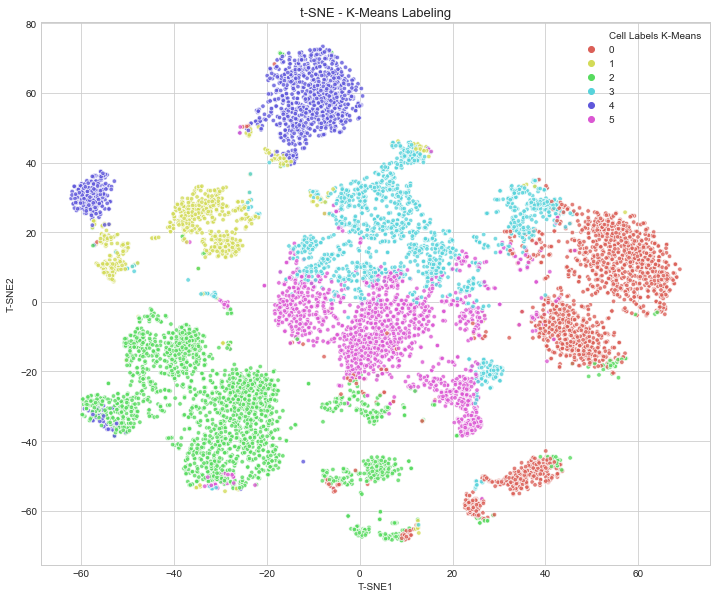

In [111]:
plt.figure(figsize = (12, 10))
sns.scatterplot(data = tsne_dataframe, 
                x = 'T-SNE1', 
                y = 'T-SNE2', 
                hue = 'Cell Labels K-Means',
                palette = sns.color_palette("hls", 6),
                alpha = 0.8,
                legend = 'full',
                s = 20).set_title('t-SNE - K-Means Labeling', fontsize = 13)
plt.show()

Well, it looks much more better than the PCA plots. The objects (cells) are significantly more granular, and there can be found clearly separable clusters in the data. Moreover, cells clustered in one group tend to be found in the same rigion of the plot, with few exceptions. But, how should we exactly interpret this plot? We can see that, for example, part of the green dots are away from the main green cluster, which, by the way, has some bilobed form. This spreadness may be due to low perplexity. The green dots (cells) in the high-dimensional space may "lie" close to each other in that space, however by selecting low perplexity we choose to look for small number of effective neighbourhood points, and that may, we may leave out some of the points that are actualy close in the high-dimensional space, to be relatively distant in the 2D space (because of the nature of working of the algorithm). The same aplies for the light blue, purple, and even the red dots. In the high-dimensional space these objects (cells) may be a part of one cluster, or they are may be 3 distinctive clusters. It is difficult to say from the above plot. This is a matter of optimization of the t-SNE's perplexity, and we will explore the separation of the cells at different values of perplexity, in a while.   

Now, we have to add something important about t-SNE. There is no objective mesure that asses the quality of the visualizations that the algorithm constructs. We can explore the quality of the visualizations only visually. t-SNE is an algorithm that does not retain distances but probabilities, so measuring some error between the Euclidean distances in high-dimension and low-dimension is useless. However, if we use the same data and perplexity, but choose different random seeds, we can compare the Kullback-Leibler divergences that t-SNE reports. This means that each time we run t-SNE with different random seed, we will get different results. This is so, because t-SNE has a non-convex objective function. The objective function is minimized using a gradient descent optimization that is initiated randomly. As Van der Maaten says, "it is perfectly fine to run t-SNE ten times, and to select the visualization with the lowest value of the objective function as your final visualization" (the solution with the lowest KL divergence).

We can demonstrate that on practice, by choosing different values for `random_state` and run the algorithm.

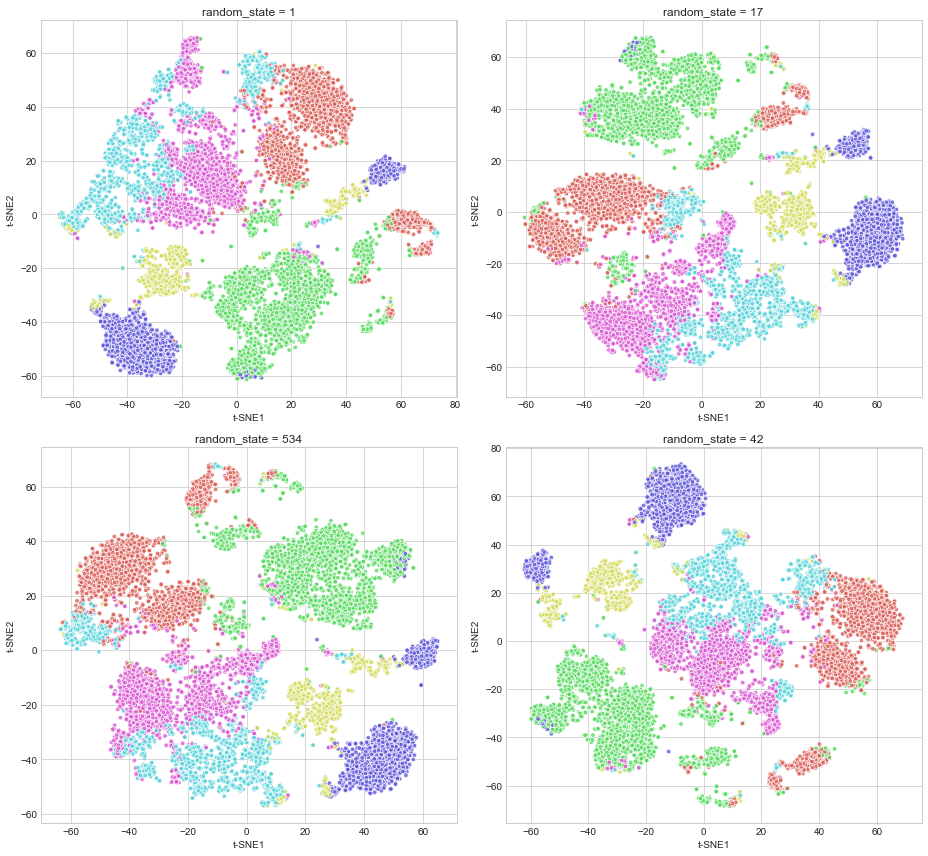

In [112]:
plt.figure(figsize = (13, 12))

random_states = [1, 17, 534, 42]

for index, r_state in enumerate(random_states):

    tsne = TSNE(n_components = 2, perplexity = 25, learning_rate = 100, random_state = r_state)
    tsne_data = tsne.fit_transform(pca_data)

    tsne_dataframe = construct_2d_dataframe_with_labels(data = tsne_data,
                                                        column_names = ['t-SNE1', 't-SNE2'],
                                                        labels = cell_labels_kmeans,
                                                        labels_name = ['Cell Labels K-Means'])

    plt.subplot(2, 2, index + 1)
    sns.scatterplot(data = tsne_dataframe, 
                    x = 't-SNE1', 
                    y = 't-SNE2',
                    hue = 'Cell Labels K-Means',
                    palette = sns.color_palette("hls", 6),
                    alpha = 0.8,
                    legend = False,
                    s = 20).set_title(f'random_state = {str(r_state)}')
    plt.tight_layout()

plt.show()

We can see that the overall grouping of the clusters is retained (with some exceptions), but the relative position and distances are changed.

Now, before we switch to examine the behaviour of our data at different values for perplexity, and different initialization of the algorithm - `random` or `pca`, we want to see how the data looks with the labels provided by `AgglomerativeClustering`.

For that purpose, we should first create a dataframe.

In [113]:
tsne_dataframe_ac = construct_2d_dataframe_with_labels(data = tsne_data,
                                                 column_names = ['t-SNE1', 't-SNE2'],
                                                 labels = agglomerative_labels,
                                                 labels_name = ['Cell Labels Agglomerative Clustering'])

In [114]:
tsne_dataframe_ac

t-SNE1     t-SNE2  Cell Labels Agglomerative Clustering
0    -59.001678  32.577663                                     0
1     27.577969 -61.933064                                     1
2     26.499763 -50.102722                                     2
3     39.758755 -49.282116                                     1
4     38.621738 -45.618565                                     1
...         ...        ...                                   ...
8902 -17.075027  48.310898                                     4
8903  -7.095774  61.213829                                     4
8904  -7.448872  28.674225                                     2
8905  59.871716  13.097460                                     1
8906 -14.570510  59.660542                                     4

[8907 rows x 3 columns]

Now we can see what we are getting.

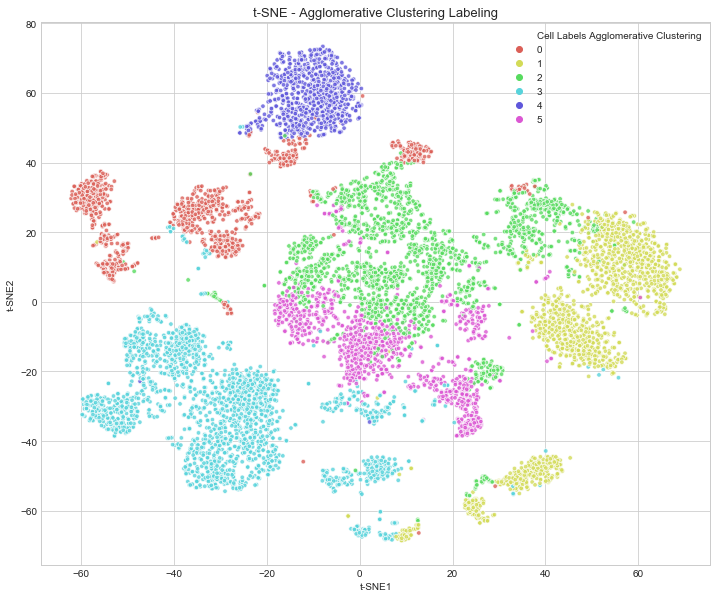

In [115]:
plt.figure(figsize = (12, 10))
sns.scatterplot(data = tsne_dataframe_ac, 
                x = 't-SNE1', 
                y = 't-SNE2', 
                hue = 'Cell Labels Agglomerative Clustering',
                palette = sns.color_palette("hls", 6),
                alpha = 0.8,
                legend = 'full',
                s = 20).set_title('t-SNE - Agglomerative Clustering Labeling', fontsize = 13)
plt.show()

We should first notice that the structure of the data is the same as that of the bottom right plot of the above graph, and is the same as that in cell number [111]. This is so because the random state for all 3 plots is the same. Otherwise, the differences in the labeling provided by k-means and agglomerative clustering look minor (aside from the change in the colors). This is due to relatively high value for `adjusted_rand_score` that we got, meaning that both clustering are robust on the same pca data.

Now, as we stated earlier, we will explore the behavour of t-SNE at different values for perplexity and with `random` and `pca` initialization, as we bear in mind that with `pca` initialization the global structure of the data must be better preserved.

Let's iterate over perplexity's values in the range (1, 75) to see what we will get as a result.

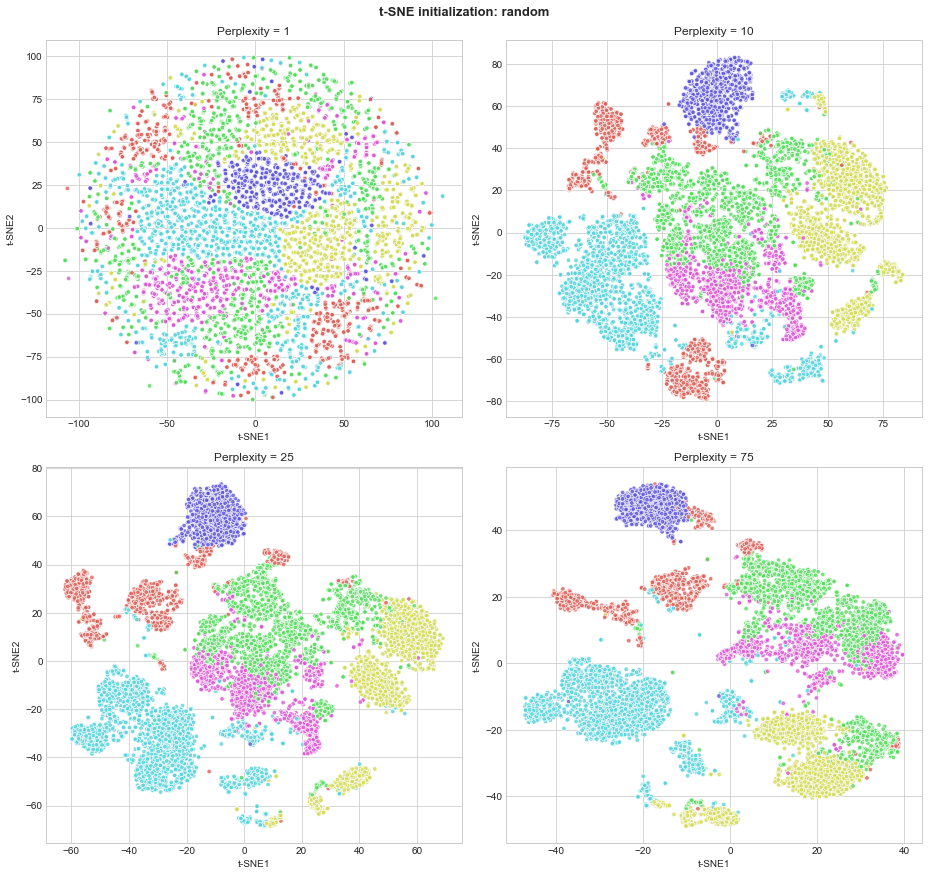

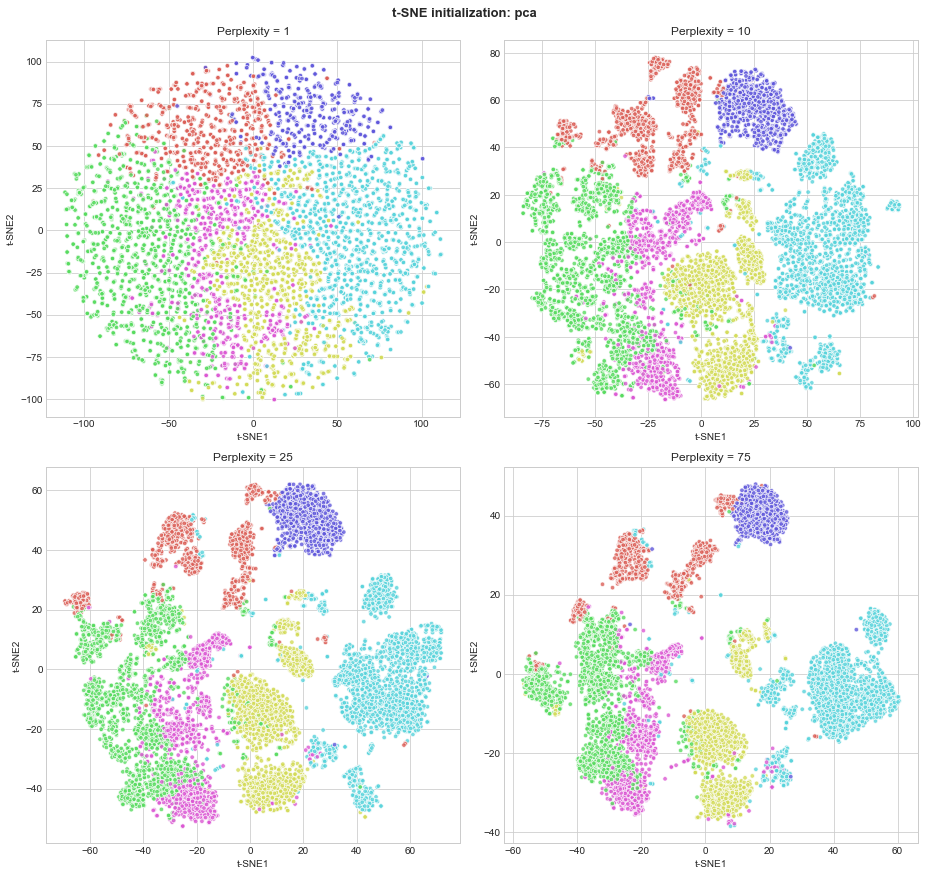

In [116]:
initialization = ['random', 'pca']
perplexity = [1, 10, 25, 75]

for init in initialization:
    plt.figure(figsize = (13, 12))
    plt.subplots_adjust(top = .5, right = .5)
    
    for index, p in enumerate(perplexity):

        tsne = TSNE(n_components = 2, perplexity = p, learning_rate = 100, init = init, random_state = 42)
        tsne_data = tsne.fit_transform(pca_data)

        tsne_dataframe = construct_2d_dataframe_with_labels(data = tsne_data,
                                                            column_names = ['t-SNE1', 't-SNE2'],
                                                            labels = agglomerative_labels,
                                                            labels_name = ['Cell Labels Agglomerative Clustering'])

        plt.subplot(2, 2, index + 1)
        sns.scatterplot(data = tsne_dataframe, 
                        x = 't-SNE1', 
                        y = 't-SNE2',
                        hue = 'Cell Labels Agglomerative Clustering',
                        palette = sns.color_palette("hls", 6),
                        alpha = 0.8,
                        legend = False,
                        s = 20).set_title(f'Perplexity = {str(p)}')
        plt.tight_layout()
        
    plt.suptitle(f't-SNE initialization: {init}', fontsize = 13, fontweight = 'bold', y = 1.01)
    plt.tight_layout()
    
plt.show()

First, indeed, there is a difference between `random` and `pca` initialization on the global structure of the data (however, we are not very sure whether pca initialization on pca data matter so much). Probably, the data is best representented at `pca` initialization with `perplexity=75`. At these hyperparameters' values, the different cell groups are best separated, and the clusters themselves are more compact. In the rest of the plots, we can see clear tendencies  of the separation of the cells, as well. We can also observe clearly the impact of perplexity on the granularity of the clusters. At `perplexity=1` all the data is represented as ball in the center of the plot, and with increasing of the perplexity paterns of the data begin to emerge. In theory, if we increase perplexity so much that in one local "neighbourhood" fall data points which are part of other more distant clusters, we will presumably get the same local balls with messed data points. Something else that also deserve to be noticed is that the green and purple clusters are almost merged together. That is either because these 2 clusters "lie" close to each other in the high-dimensional space (the cells in both clusters are "similar" to each other) or because we chose wrong $k$ for `n_clusters`. The best way to decide whether this is one cluster or two is to look for marker genes in both clusters and then to search the internet for characteristic expression of those genes in different podocyte subpopulations. This way we can annotate some of the cells (get "true" labels), and thus to bring our task to semi-supervised learning. This is, however, a bit of complicated task, plus it is not part of the objectives of this project. We simply aim at comparing the overall performance of the algorithms on scRNA-seq data. For now we can only conclude that at `pca` initialization and `perplexity=75` we are getting the best visualization of our data.

Now, let's enter UMAP.

### 3. Dimensionality Reduction and Visualization with UMAP

t-SNE is considered the current state-of-the-art technique for visualization of complex high-dimensional data. We saw the superiority in the performance of t-SNE in comparison to PCA. Nonetheless, t-SNE has its drawbacks, as well. Most notably, it fails to preserve the global structure of the data, it is sluggish, and it is designed to reduce the data to only two dimensions, so it can not be used as general purpose dimension reduction technique. By contrast, UMAP is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction. 

Uniform Manifold Approximation and Projection (UMAP) is an algorithm constructed on theoretical framework based in Riemannian geometry and algebraic topology. Math behind UMAP is really advanced and we are not going to go in-depth into explaining something that we barely understand. However, we will outline the basic assumptions behind the algorithm and how it works. First of all, UMAP is the work of Leland McInnes introduced in 2018 in its paper - "UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction" [4]. That paper is firmly mathematical and its underpinnings liе into topological data analysis and Riemannian geometry. It sounds scary and it is scary for reader without a background in topological data analysis to try to understand this paper. Nonetheless, searching the internet one can find fairly understandable explanations of UMAP. So, put simply, UMAP is a graph layout algorithm that arrange high-dimensional data into low-dimensional space. In the simplest sense, UMAP constructs a high-dimensional graph representation of the data then optimizes a low-dimensional graph to be as structurally similar as possible. In order to construct the initial high-dimensional graph, UMAP builds something called a "fuzzy simplicial complex", which is just weighted graph, with edge weights representing the likelihood that two points are connected. Then, from each point UMAP extends a radius as trying to connect near points when those radii overlap. Choosing the radii is critical step as too small radii will lead to isolated clusters, while too large will connect all together. This is overcomed as each radius is chosen locally based on the distance to each point's $n$-th nearest neighbor. Next, UMAP creates the "fuzzy" graph by decreasing the likelihood of connection as the radius grows. Finally, each point is connected to its nearest points, thus UMAP ensures that local structure is preserved in balance with global structure. Once the high-dimensional graph is constructed, UMAP optimizes the layout of a low-dimensional analogue to be as similar as possible. 

Now, without no more worrying about the theory behind UMAP let's switch to the implemention of UMAP. 

First, the Python implementation of UMAP is part of the umap-learn package. The umap package inherits from scikit-learn classes, and thus drops in neatly next to other scikit-learn transformers with an identical calling API.  

Following the above, we must first instantiate an umap object. There are a number of parameters that can be set for the UMAP class as the major one is `n_neighbors`. This parameter determines the size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation. We will leave this parameter as it is by default 40. Later we will test its influence on the embedding of the data over a range of values. One advantage of UMAP over t-SNE is that we may choose the dimensions of space to embed the data into. For visualization it is 2 by default, but it can be set to any integer value in the range 2 to 100. Thereby, UMAP ca be used as general purpose dimension reduction algorithm. Another important parameter is `min_dist`. This controls how tightly the embedding is allowed to compress points together. Larger values ensure embedded points are more evenly distributed, while smaller values allow the algorithm to optimise more accurately with regard to local structure. We will also test the impact of different values over the embedding. For now, we will leave it by default 0.1.

Now, let's create an UMAP object.

In [117]:
umap = UMAP(n_neighbors = 40, n_components = 2, min_dist = 0.1, random_state = 42)

We can now use the `fit_transform` method on the UMAP object.

In [118]:
umap_data = umap.fit_transform(pca_data)

Now, we can make a dataframe from the first two embeddings obtained by UMAP. First, we will use the k-means labels to label the data, then we will use those obtained by the agglomerative clustering.

In [119]:
umap_dataframe = construct_2d_dataframe_with_labels(data = umap_data,
                                              column_names = ['UMAP-1', 'UMAP-2'],
                                              labels = cell_labels_kmeans,
                                              labels_name = ['Cell Labels K-Means'])

In [120]:
umap_dataframe

UMAP-1     UMAP-2  Cell Labels K-Means
0      7.634572   4.374829                    4
1     -4.292963   0.125461                    0
2     -4.910646   0.146452                    0
3     -4.599741   0.826183                    0
4     -4.557779   0.887897                    0
...         ...        ...                  ...
8902  14.024407  12.170853                    4
8903  15.104323  12.133737                    4
8904   4.879969  11.339206                    1
8905  -6.816206  10.022919                    0
8906  14.654711  11.785964                    4

[8907 rows x 3 columns]

Let's see what representation of the data we will get.

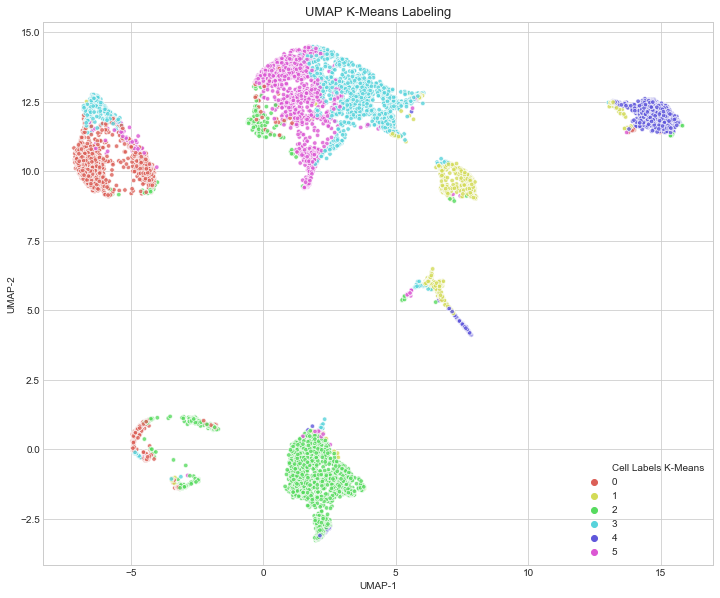

In [121]:
plt.figure(figsize = (12, 10))
sns.scatterplot(data = umap_dataframe, 
                x = 'UMAP-1', 
                y = 'UMAP-2', 
                hue = 'Cell Labels K-Means',
                palette = sns.color_palette("hls", 6),
                alpha = 0.8,
                legend = 'full',
                s = 20).set_title('UMAP K-Means Labeling', fontsize = 13)
plt.show()

Well, the clusters are much more well-difined than those obtained by t-SNE. We can see 3 large well-separable clusters and 4 smaller group of cells. Distances between different clusters are clearly visible, in contrast to those presented by t-SNE. It is interesting to compare this plot to the one with largest perplexity obtained by t-SNE. First, the number of clusters are the same or nearly the same. It is a bit tricky for us to assess the exact number of clusters provided by t-SNE due to the lack of clear boundary between the different group of cells, while the clusters onto the UMAP plot are easily distinguishable. When it comes to the labels, the largest cluster on the t-SNE plots is labeled with 2 colors, here is the same. This suggest for clear agreement between t-SNE and UMAP onto the embedding of the data into 2D space. Overall, however, UMAP provides much clearer representation of the data and its corresponding clustering. 

Now, let's see the labeling provided by agglomerative clustering onto the UMAP embedding of the data.

In [122]:
umap_dataframe_ac = construct_2d_dataframe_with_labels(data = umap_data,
                                              column_names = ['UMAP-1', 'UMAP-2'],
                                              labels = agglomerative_labels,
                                              labels_name = ['Cell Labels Agglomerative Clustering'])

In [123]:
umap_dataframe_ac

UMAP-1     UMAP-2  Cell Labels Agglomerative Clustering
0      7.634572   4.374829                                     0
1     -4.292963   0.125461                                     1
2     -4.910646   0.146452                                     2
3     -4.599741   0.826183                                     1
4     -4.557779   0.887897                                     1
...         ...        ...                                   ...
8902  14.024407  12.170853                                     4
8903  15.104323  12.133737                                     4
8904   4.879969  11.339206                                     2
8905  -6.816206  10.022919                                     1
8906  14.654711  11.785964                                     4

[8907 rows x 3 columns]

Let's see.

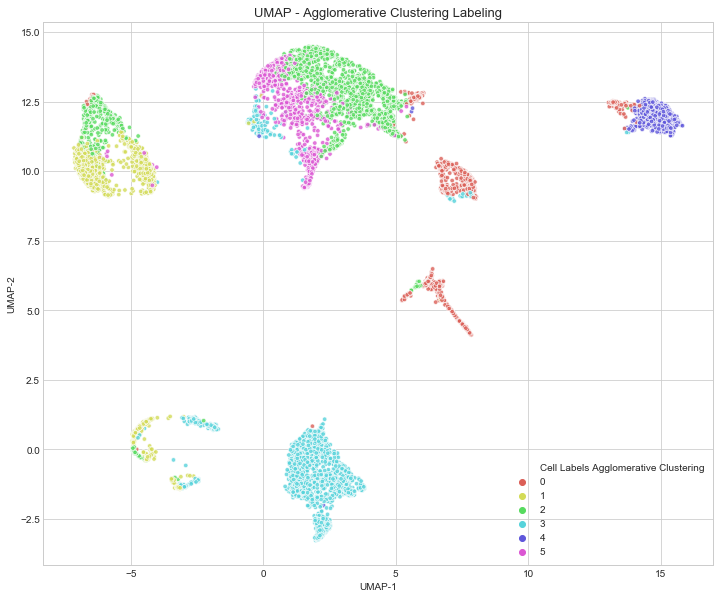

In [124]:
plt.figure(figsize = (12, 10))
sns.scatterplot(data = umap_dataframe_ac, 
                x = 'UMAP-1', 
                y = 'UMAP-2', 
                hue = 'Cell Labels Agglomerative Clustering',
                palette = sns.color_palette("hls", 6),
                alpha = 0.8,
                legend = 'full',
                s = 20).set_title('UMAP - Agglomerative Clustering Labeling', fontsize = 13)
plt.show()

Some minor differences in the largest cluster, as it were expected. 

Now, if the most important t-SNE's parametеr for optimization is `perplexity`, for UMAP these are `n_neighbors` and `min_dist`. We will iterate through different values for `n_neighbors` and `min_dist` to see how the different values affect the embedding of the data. In general `n_neighbors` should often be in the range 5 to 50, with a choice of 10 to 15 being a sensible default. For `min_dist` sensible values are in the range 0.001 to 0.5, with 0.1 being a reasonable default.

Let's see how these parameters influence the embedding.

C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\user\anaconda3\lib\site-packages\umap\spectral.py:253: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
C:\Users\user\anaconda3\lib\site-packages\umap\spectral.py:253: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


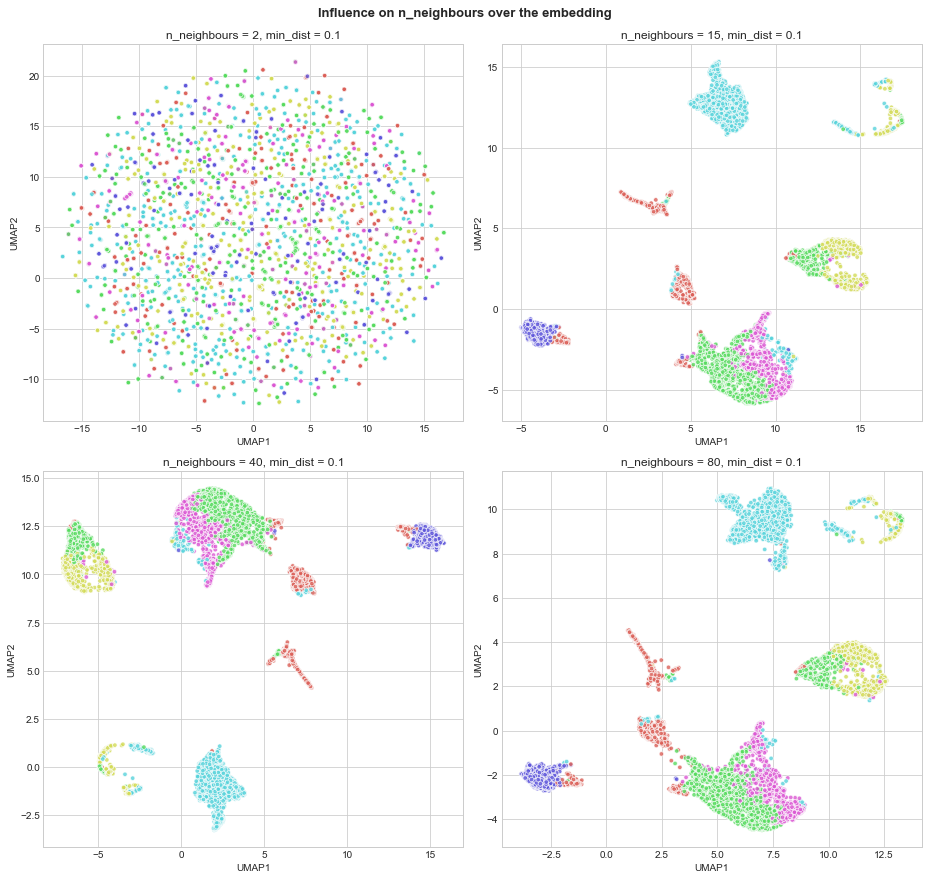

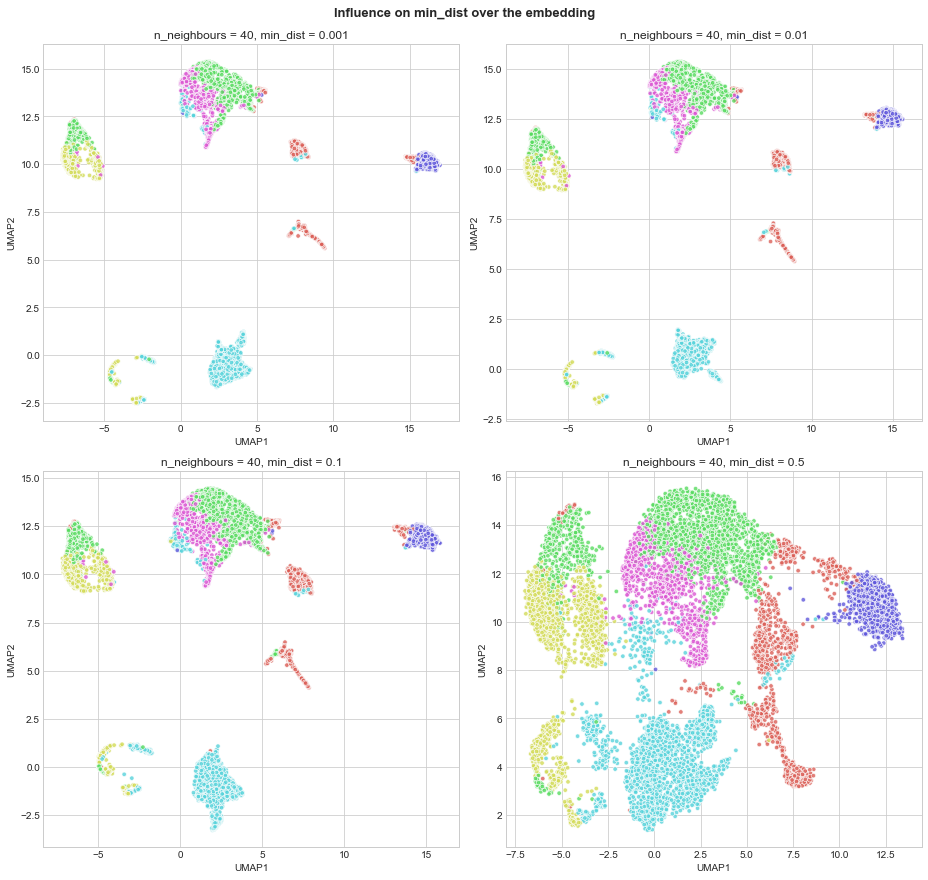

In [125]:
parameters = [[(2, 0.1), (15, 0.1), (40, 0.1), (80, 0.1)],
             [(40, 1e-3), (40, 1e-2), (40, 1e-1), (40, 0.5)]] 

param_influence = 'n_neighbours'

for param in parameters:
    plt.figure(figsize = (13, 12))
    plt.subplots_adjust(top = .5, right = .5)
    
    for index, p in enumerate(param):

        umap = UMAP(n_neighbors = p[0], n_components = 2, min_dist = p[1], random_state = 42)
        umap_data = umap.fit_transform(pca_data)

        umap_dataframe = construct_2d_dataframe_with_labels(data = umap_data,
                                                            column_names = ['UMAP1', 'UMAP2'],
                                                            labels = agglomerative_labels,
                                                            labels_name = ['Cell Labels Agglomerative Clustering'])

        plt.subplot(2, 2, index + 1)
        sns.scatterplot(data = umap_dataframe, 
                        x = 'UMAP1', 
                        y = 'UMAP2',
                        hue = 'Cell Labels Agglomerative Clustering',
                        palette = sns.color_palette("hls", 6),
                        alpha = 0.8,
                        legend = False,
                        s = 20).set_title(f'n_neighbours = {p[0]}, min_dist = {p[1]}')
        plt.tight_layout()
        
    plt.suptitle(f'Influence on {param_influence} over the embedding', 
                 fontsize = 13, 
                 fontweight = 'bold', 
                 y = 1.015)
    param_influence = 'min_dist'
    plt.tight_layout()
    
plt.show()

Well, we can see that there are no substantial differences in the plots where `n_neighbours` varies in the range 15 - 80, and we have good overall view of the data over the entire range. As regards `min_dist`, values in the range 0.001 - 0.1 result in a more clumped embedding where nearby points on the manifold are drawn closer together, while `min_dist=0.5` results in a more even dispersal of the points. On the whole, we can conclude that UMAP gives good visualization of the data at broad range of values for `n_neighbors` and `min_dist`, while t-SNE's perplexity requires much more fine tuning.

Now, let's switch to evaluate t-SNE and UMAP with respect to running time. For that purpose we will first define a utility function that construct a model, and then will measure the respective times.

In [126]:
def construct_model(model_of_interest, data, n_components = None, random_state = 42):
    """
    Instantiate and fit_transform a model of interest with pca data.
    """
    pca = PCA(n_components = 50).fit_transform(data)
    model = model_of_interest(n_components = n_components, random_state = random_state)
    model_data = model.fit_transform(pca)
    
    return model_data

Let's see which algorithm is faster.

In [127]:
time = Timer(lambda: construct_model(model_of_interest = UMAP, data = filtered_normalized_counts, n_components = 2))
print(f'Execution time - UMAP: {time.timeit(number = 1):.2f} sec.')

Execution time - UMAP: 15.18 sec.


In [128]:
time = Timer(lambda: construct_model(model_of_interest = TSNE, data = filtered_normalized_counts, n_components = 2))
print(f'Execution time - t-SNE: {time.timeit(number = 1):.2f} sec.')

Execution time - t-SNE: 46.87 sec.


Well, it turned out that UMAP is nearly 2.5 times faster than t-SNE.

### V. Discussion

scRNA-seq is a powerful new technology that enables researchers to simultaneously profile thousands of genes at single-cell resolution, which makes it an ideal tool to study the cell-to-cell heterogeneity in the contex of many life science research areas, such as developmental biology, oncology, and immunology among others. scRNA-seq experiments yield ever growing datasets containing RNA expression levels for thousands of genes from many thousands up to millions of cells. Computational analysis of such datasets often entails unsupervised, exploratory steps including dimensionality reduction for data visualisation. Visualization of the high-dimensional RNA-seq data is critical for detecting cell subpopulations and revealing biological insights from the data.

Throughout this project we walked through the comparing of three most commonly used techniques for dimensionality reduction and visualization, namely PCA, t-SNE, and UMAP. Each of these techniques has its relative strengths and weaknesses when it comes to visualizing scRNA-seq data. We saw that PCA did not work quite well when we had to project the data for visualization using the first two principal components. It failed to present any meaningful picture of the underlying structure in the data. Presumably this is due to the absence of linear structure in the same these data. Nevertheless, PCA is an indispensable tool in any scRNA-seq data analysis because of its general dimension reduction capabilities. It can project high-dimensional data to reasonably few principal components while encompassing desired amount of variation in the data. These feature extraction abilities rander PCA very suitable preprocessing algorithm for other dimension reduction and visualization techniques, in particular t-SNE. 

On the other hand, t-SNE is the current state-of-the-art technique for visualization of scRNA-seq data. We saw its superiority in the representation of the data with comparison to the PCA. t-SNE is a manifold learning algorithm that is especially useful in preserving the local ctructure of the high-dimensional data onto a 2D graph. This is done by assigning high probabilities to similar objects in the high-dimensional space and low probabilities to dissimilar objects. Then it uses these probabilities to embed the data into a 2D manifold while trying to minimize the Kullback–Leibler divergence between the both probability distribution. The most important t-SNE's hyperparameter for optimization is perplexity. It needs fine tuning in order t-SNE to be able to present well-separable clusters. Moreover, the initialization of the embedding also matter, as we saw that `init=PCA` preserve the global structure of the data better. Conceivably the most significant drawback of t-SNE is its low scalability to really high-dimensional datasets due to computational complexity. This is because t-SNE has a quadratic time and space complexity in the number of data points. This makes it particularly slow and computationally quite heavy while applying it to datasets comprising of more than 10,000 observations. Solution to this problem is using both PCA and t-SNE in conjunction.

As regards UMAP, we saw clearly that it outperformed both PCA and t-SNE in terms of visualization of our scRNA-seq data. In terms of computational time, UMAP is nearly 2.5 times faster than t-SNE on PCA data with 50 PCs. Presumably, UMAP will be much more faster on real high-dimensional data than t-SNE. Another problem faced by t-SNE is the limitation of the number of dimension that it embeds the data into. This is so, because t-SNE solves a problem known as the crowding problem. Put simply, with increasing the number of dimensions the crowding problem is less severe than when you embed in two dimensions. As a result, t-SNE is performing worse when it have to embed the data into higher manifold. This limitation does not apply to UMAP. UMAP can be used as non-linear general dimension reduction algorithm.  Thereby, it can serve as preprocessing step for reducing the dimensionality for other machine learning algorithms, especially when the data exhibits non-linear patterns. Something more, we saw that UMAP is also much more stable in wide range of `n_neighbours`, whereas t-SNE require much more fine tuning of its perplexity. Therefore, taking all these into account, we can conclude that UMAP performed best compared to PCA and t-SNE geven our scRNA-seq data.

### VI. References

1. Fuchou Tang, Catalin Barbacioru, Yangzhou Wang, _et al._ 2009. mRNA-Seq Whole-transcriptome Analysis of a Single Cell. Nature Methods volume 6, pages 377–382 (2009). DOI: 10.1038/nmeth.1315. 


2. Tracy Tran, Andrew Ransick _et al._ 2019. In Vivo Developmental Trajectories of Human Podocyte Inform In Vitro Differentiation of Pluripotent Stem Cell-Derived Podocytes. Dev Cell. 2019 Jul 1;50(1):102-116.e6. doi: 10.1016/j.devcel.2019.06.001. 


3. L.J.P. van der Maaten and G.E. Hinton, 2008. Visualizing High-Dimensional Data Using t-SNE. Journal of Machine Learning Research 9(Nov):2579-2605.


4. Leland McInnes, John Healy, James Melville, 2020. UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction. arXiv:1802.03426.


5. Dmitry Kobak, Philipp Berens, 2019. The Art of Using t-SNE for Single-Cell Transcriptomics. Nat Commun. 2019 Nov 28;10(1):5416. doi: 10.1038/s41467-019-13056-x


6. Malte Luecken, Fabian Theis, 2019. Current Best Practices in Single-Cell RNA-seq Analysis: a Tutorial. Mol Syst Biol. 2019 Jun 19;15(6):e8746. doi: 10.15252/msb.20188746. 